In [1]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [2]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

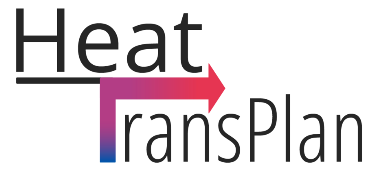


<div style="text-align: center; font-size: 50px;">
    <b>Energy and Sensor mapping on Process Data</b>
</div>

## Index
- [Define Paths and Load Datasets](#define-paths-and-load-datasets)
    - [Define Paths](#define-paths)
    - [Load Datasets](#load-datasets)
    - [Data Transformation and Cleaning](#data-transformation-and-cleaning)
- [Merge Datasets](#merge-datasets)
- [Map Energy Data to Activities](#map-energy-data-to-activities)
    - [Map Electricity & Steam to each Activity](#map-electricity--steam-to-each-activity)
        - [Electricity](#electricity)
        - [Steam](#steam)
    - [Calculate Electricity and Steam Consmption for the whole Process](#calculate-electricity-and-steam-consumption-for-the-whole-process)
- [Merge Sensor Data](#merge-sensor-data)
    - [Merge Sensor Data on Activity Level](#merge-sensor-data-on-activity-level)
    - [Merge Sensor Data on Process Level](#merge-sensor-data-on-process-level)


In [3]:

import random
import itertools
import os
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
#import simulation
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chardet
import plotly.io as pio
from pathlib import Path
import pm4py
pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None

# Define Paths and Load Datasets

## Define Paths

In [4]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/silver/aixit' folder relative to the current path
files_folder_silver = current_path.parent / 'data' / 'silver' / 'company_2'


## Load Datasets

In [5]:
# Load the Parquet file
df = pd.read_parquet(files_folder_silver / "df_combined_legend.parquet")

df

,datetime,schritt_l01_,pro_menge_l01_kg,pro_menge_l02_kg,schritt_l02_,pro_temp_out_l01_,pro_temp_out_l02_,mat_id_m01_,mat_id_m02_,mat_id_m03_,...,medium_temp_ein_l01,medium_temp_ein_l02_,dampfmenge_kg/h_nmb+cip_,cip_turm_f_,cip_turm_g_,status_name_l01,status_name_l02,pro_power_kW_l01,pro_power_kW_l02,medium_power_kW
0,2024-11-03 14:03:21,0,0.0,0.0,0,31.201172,29.909939,0,0,0,...,33.582901,30.777994,574.001709,0,0,Grundstellung,Grundstellung,0.000000,0.0,334.834330
1,2024-11-03 14:03:26,0,0.0,0.0,0,31.201172,29.915365,0,0,0,...,33.582901,30.777994,533.130798,0,0,Grundstellung,Grundstellung,0.000000,0.0,310.992966
2,2024-11-03 14:03:31,0,0.0,0.0,0,31.201172,29.909939,0,0,0,...,33.582901,30.777994,497.685181,0,0,Grundstellung,Grundstellung,0.000000,0.0,290.316355
3,2024-11-03 14:03:36,0,0.0,0.0,0,31.201172,29.909939,0,0,0,...,33.582901,30.772570,485.387726,0,0,Grundstellung,Grundstellung,0.000000,0.0,283.142840
4,2024-11-03 14:03:41,0,0.0,0.0,0,31.195747,29.909939,0,0,0,...,33.582901,30.783421,498.408569,0,0,Grundstellung,Grundstellung,0.000000,0.0,290.738332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368723,2024-11-24 22:10:16,0,0.0,0.0,0,63.677299,26.844618,0,0,0,...,69.238281,28.059896,3.978588,0,30,Grundstellung,Grundstellung,1020.215826,0.0,2.320843
368724,2024-11-24 22:10:21,0,0.0,0.0,0,63.709854,26.844618,0,0,0,...,69.194878,28.054470,0.000000,0,30,Grundstellung,Grundstellung,1031.460454,0.0,0.000000
368725,2024-11-24 22:10:26,0,0.0,0.0,0,63.736980,26.844618,0,0,0,...,69.135201,28.059896,0.000000,0,30,Grundstellung,Grundstellung,1042.125419,0.0,0.000000
368726,2024-11-24 22:10:31,0,0.0,0.0,0,63.764107,26.833767,0,0,0,...,69.102646,28.054470,0.000000,0,30,Grundstellung,Grundstellung,1052.476826,0.0,0.000000


In [6]:
df

,datetime,schritt_l01_,pro_menge_l01_kg,pro_menge_l02_kg,schritt_l02_,pro_temp_out_l01_,pro_temp_out_l02_,mat_id_m01_,mat_id_m02_,mat_id_m03_,...,medium_temp_ein_l01,medium_temp_ein_l02_,dampfmenge_kg/h_nmb+cip_,cip_turm_f_,cip_turm_g_,status_name_l01,status_name_l02,pro_power_kW_l01,pro_power_kW_l02,medium_power_kW
0,2024-11-03 14:03:21,0,0.0,0.0,0,31.201172,29.909939,0,0,0,...,33.582901,30.777994,574.001709,0,0,Grundstellung,Grundstellung,0.000000,0.0,334.834330
1,2024-11-03 14:03:26,0,0.0,0.0,0,31.201172,29.915365,0,0,0,...,33.582901,30.777994,533.130798,0,0,Grundstellung,Grundstellung,0.000000,0.0,310.992966
2,2024-11-03 14:03:31,0,0.0,0.0,0,31.201172,29.909939,0,0,0,...,33.582901,30.777994,497.685181,0,0,Grundstellung,Grundstellung,0.000000,0.0,290.316355
3,2024-11-03 14:03:36,0,0.0,0.0,0,31.201172,29.909939,0,0,0,...,33.582901,30.772570,485.387726,0,0,Grundstellung,Grundstellung,0.000000,0.0,283.142840
4,2024-11-03 14:03:41,0,0.0,0.0,0,31.195747,29.909939,0,0,0,...,33.582901,30.783421,498.408569,0,0,Grundstellung,Grundstellung,0.000000,0.0,290.738332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368723,2024-11-24 22:10:16,0,0.0,0.0,0,63.677299,26.844618,0,0,0,...,69.238281,28.059896,3.978588,0,30,Grundstellung,Grundstellung,1020.215826,0.0,2.320843
368724,2024-11-24 22:10:21,0,0.0,0.0,0,63.709854,26.844618,0,0,0,...,69.194878,28.054470,0.000000,0,30,Grundstellung,Grundstellung,1031.460454,0.0,0.000000
368725,2024-11-24 22:10:26,0,0.0,0.0,0,63.736980,26.844618,0,0,0,...,69.135201,28.059896,0.000000,0,30,Grundstellung,Grundstellung,1042.125419,0.0,0.000000
368726,2024-11-24 22:10:31,0,0.0,0.0,0,63.764107,26.833767,0,0,0,...,69.102646,28.054470,0.000000,0,30,Grundstellung,Grundstellung,1052.476826,0.0,0.000000


In [7]:
df.columns

Index(['datetime', 'schritt_l01_', 'pro_menge_l01_kg', 'pro_menge_l02_kg',
       'schritt_l02_', 'pro_temp_out_l01_', 'pro_temp_out_l02_', 'mat_id_m01_',
       'mat_id_m02_', 'mat_id_m03_', 'pro_volstrom_l01_l/h',
       'pro_volstrom_l02_l/h', 'medium_temp_ein_l01', 'medium_temp_ein_l02_',
       'dampfmenge_kg/h_nmb+cip_', 'cip_turm_f_', 'cip_turm_g_',
       'status_name_l01', 'status_name_l02', 'pro_power_kW_l01',
       'pro_power_kW_l02', 'medium_power_kW'],
      dtype='object')

In [8]:
df

,datetime,schritt_l01_,pro_menge_l01_kg,pro_menge_l02_kg,schritt_l02_,pro_temp_out_l01_,pro_temp_out_l02_,mat_id_m01_,mat_id_m02_,mat_id_m03_,...,medium_temp_ein_l01,medium_temp_ein_l02_,dampfmenge_kg/h_nmb+cip_,cip_turm_f_,cip_turm_g_,status_name_l01,status_name_l02,pro_power_kW_l01,pro_power_kW_l02,medium_power_kW
0,2024-11-03 14:03:21,0,0.0,0.0,0,31.201172,29.909939,0,0,0,...,33.582901,30.777994,574.001709,0,0,Grundstellung,Grundstellung,0.000000,0.0,334.834330
1,2024-11-03 14:03:26,0,0.0,0.0,0,31.201172,29.915365,0,0,0,...,33.582901,30.777994,533.130798,0,0,Grundstellung,Grundstellung,0.000000,0.0,310.992966
2,2024-11-03 14:03:31,0,0.0,0.0,0,31.201172,29.909939,0,0,0,...,33.582901,30.777994,497.685181,0,0,Grundstellung,Grundstellung,0.000000,0.0,290.316355
3,2024-11-03 14:03:36,0,0.0,0.0,0,31.201172,29.909939,0,0,0,...,33.582901,30.772570,485.387726,0,0,Grundstellung,Grundstellung,0.000000,0.0,283.142840
4,2024-11-03 14:03:41,0,0.0,0.0,0,31.195747,29.909939,0,0,0,...,33.582901,30.783421,498.408569,0,0,Grundstellung,Grundstellung,0.000000,0.0,290.738332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368723,2024-11-24 22:10:16,0,0.0,0.0,0,63.677299,26.844618,0,0,0,...,69.238281,28.059896,3.978588,0,30,Grundstellung,Grundstellung,1020.215826,0.0,2.320843
368724,2024-11-24 22:10:21,0,0.0,0.0,0,63.709854,26.844618,0,0,0,...,69.194878,28.054470,0.000000,0,30,Grundstellung,Grundstellung,1031.460454,0.0,0.000000
368725,2024-11-24 22:10:26,0,0.0,0.0,0,63.736980,26.844618,0,0,0,...,69.135201,28.059896,0.000000,0,30,Grundstellung,Grundstellung,1042.125419,0.0,0.000000
368726,2024-11-24 22:10:31,0,0.0,0.0,0,63.764107,26.833767,0,0,0,...,69.102646,28.054470,0.000000,0,30,Grundstellung,Grundstellung,1052.476826,0.0,0.000000


In [9]:
df.columns

Index(['datetime', 'schritt_l01_', 'pro_menge_l01_kg', 'pro_menge_l02_kg',
       'schritt_l02_', 'pro_temp_out_l01_', 'pro_temp_out_l02_', 'mat_id_m01_',
       'mat_id_m02_', 'mat_id_m03_', 'pro_volstrom_l01_l/h',
       'pro_volstrom_l02_l/h', 'medium_temp_ein_l01', 'medium_temp_ein_l02_',
       'dampfmenge_kg/h_nmb+cip_', 'cip_turm_f_', 'cip_turm_g_',
       'status_name_l01', 'status_name_l02', 'pro_power_kW_l01',
       'pro_power_kW_l02', 'medium_power_kW'],
      dtype='object')

In [10]:
import pandas as pd
from pathlib import Path

# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Define the folder path
files_folder_silver = current_path.parent / 'data' / 'silver' / 'company_2'

# Load the Parquet file
df = pd.read_parquet(files_folder_silver / "df_combined_legend.parquet")

# Identify shared columns: those without 'l01' or 'l02' in the name, excluding 'datetime' and mat_id (but mat_id are shared)
shared_columns = [col for col in df.columns if not any(x in col.lower() for x in ['l01', 'l02']) and col not in ['datetime']]

# Columns for L01: those containing 'l01' (case insensitive), plus 'datetime', mat_id columns, and shared columns
l01_columns = ['datetime'] + [col for col in df.columns if 'l01' in col.lower()] + shared_columns

# Columns for L02: those containing 'l02' (case insensitive), plus 'datetime', mat_id columns, and shared columns
l02_columns = ['datetime'] + [col for col in df.columns if 'l02' in col.lower()] + shared_columns

# Create separate DataFrames
df_l01 = df[l01_columns].copy()
df_l02 = df[l02_columns].copy()

# Rename columns in df_l01 to remove 'l01' related suffixes/prefixes
df_l01.columns = [col.replace('_l01', '').replace('l01_', '').replace('l01', '') for col in df_l01.columns]

# Rename columns in df_l02 to remove 'l02' related suffixes/prefixes
df_l02.columns = [col.replace('_l02', '').replace('l02_', '').replace('l02', '') for col in df_l02.columns]

# Ensure both DataFrames have the same columns for appending (after renaming)
common_columns = list(set(df_l01.columns) & set(df_l02.columns))
df_l01 = df_l01[common_columns]
df_l02 = df_l02[common_columns]

# Append the DataFrames
df_combined = pd.concat([df_l01.assign(temp_object='l01'), df_l02.assign(temp_object='l02')], ignore_index=True)

# Set the required columns
df_combined['higher_level_activity'] = 'shift'
df_combined['object_type'] = 'production_line'
df_combined['object'] = df_combined['temp_object']
df_combined['activity'] = df_combined['status_name']

# Set timestamps: for each activity instance, timestamp_start is the datetime when it started, timestamp_end is the datetime when it ended (next in sequence for that object)
df_combined['timestamp_start'] = df_combined['datetime']
df_combined['timestamp_end'] = df_combined.groupby('temp_object')['datetime'].shift(-1)
# For the last activity in each object's sequence, set timestamp_end to timestamp_start (or handle as needed)
df_combined['timestamp_end'] = df_combined['timestamp_end'].fillna(df_combined['datetime'])

# Set case_id, e.g., based on object and index
df_combined['case_id'] = 1#df_combined['object'] + '_' + df_combined.index.astype(str)

# Set object_attributes
df_combined['object_attributes'] = df_combined.apply(
    lambda row: {col: row[col] for col in df.columns if col.startswith('mat_id_m01_') or col.startswith('mat_id_m02_') or col.startswith('mat_id_m03_')},
    axis=1
)

# Drop unwanted columns: schritt_, mat_id_m01_, mat_id_m02_, mat_id_m03_, status_name, temp_object
df_combined = df_combined.drop(columns=[col for col in df_combined.columns if 'schritt_' in col or 'mat_id_m01_' in col or 'mat_id_m02_' in col or 'mat_id_m03_' in col or col == 'status_name' or col == 'temp_object'], errors='ignore')

# Add _log suffix to activity columns
activity_cols = ['case_id', 'activity', 'timestamp_start', 'timestamp_end', 'object', 'object_type', 'higher_level_activity', 'object_attributes']
df_combined = df_combined.rename(columns={col: col + '_log' for col in activity_cols if col in df_combined.columns})

# Add _sensor suffix to datetime and sensor columns
sensor_cols = ['datetime'] + [col for col in df_combined.columns if col not in activity_cols + ['temp_object'] and not col.endswith('_log')]
df_combined = df_combined.rename(columns={col: col + '_energy' for col in sensor_cols if col in df_combined.columns})

df_object_1 = df_combined.copy()

df_combined.head()

,pro_volstrom_l/h_energy,cip_turm_f__energy,pro_menge_kg_energy,cip_turm_g__energy,pro_power_kW_energy,medium_power_kW_energy,dampfmenge_kg/h_nmb+cip__energy,datetime_energy,pro_temp_out__energy,higher_level_activity_log,object_type_log,object_log,activity_log,timestamp_start_log,timestamp_end_log,case_id_log,object_attributes_log
0,0.0,0,0.0,0,0.0,334.834330,574.001709,2024-11-03 14:03:21,31.201172,shift,production_line,l01,Grundstellung,2024-11-03 14:03:21,2024-11-03 14:03:26,1,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
1,0.0,0,0.0,0,0.0,310.992966,533.130798,2024-11-03 14:03:26,31.201172,shift,production_line,l01,Grundstellung,2024-11-03 14:03:26,2024-11-03 14:03:31,1,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
2,0.0,0,0.0,0,0.0,290.316355,497.685181,2024-11-03 14:03:31,31.201172,shift,production_line,l01,Grundstellung,2024-11-03 14:03:31,2024-11-03 14:03:36,1,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
3,0.0,0,0.0,0,0.0,283.142840,485.387726,2024-11-03 14:03:36,31.201172,shift,production_line,l01,Grundstellung,2024-11-03 14:03:36,2024-11-03 14:03:41,1,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
4,0.0,0,0.0,0,0.0,290.738332,498.408569,2024-11-03 14:03:41,31.195747,shift,production_line,l01,Grundstellung,2024-11-03 14:03:41,2024-11-03 14:03:46,1,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."


In [11]:
# import pandas as pd
# from pathlib import Path

# # Define the path to the current file's location
# current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# # Define the folder path
# files_folder_silver = current_path.parent / 'data' / 'silver' / 'company_2'

# # Load the Parquet file
# df = pd.read_parquet(files_folder_silver / "df_combined_legend.parquet")

# # Identify shared columns: those without 'l01' or 'l02' in the name, excluding 'datetime' and mat_id (but mat_id are shared)
# shared_columns = [col for col in df.columns if not any(x in col.lower() for x in ['l01', 'l02']) and col not in ['datetime']]

# # Columns for L01: those containing 'l01' (case insensitive), plus 'datetime', mat_id columns, and shared columns
# l01_columns = ['datetime'] + [col for col in df.columns if 'l01' in col.lower()] + shared_columns

# # Columns for L02: those containing 'l02' (case insensitive), plus 'datetime', mat_id columns, and shared columns
# l02_columns = ['datetime'] + [col for col in df.columns if 'l02' in col.lower()] + shared_columns

# # Create separate DataFrames
# df_l01 = df[l01_columns].copy()
# df_l02 = df[l02_columns].copy()

# # Rename columns in df_l01 to remove 'l01' related suffixes/prefixes
# df_l01.columns = [col.replace('_l01', '').replace('l01_', '').replace('l01', '') for col in df_l01.columns]

# # Rename columns in df_l02 to remove 'l02' related suffixes/prefixes
# df_l02.columns = [col.replace('_l02', '').replace('l02_', '').replace('l02', '') for col in df_l02.columns]

# # Ensure both DataFrames have the same columns for appending (after renaming)
# common_columns = list(set(df_l01.columns) & set(df_l02.columns))
# df_l01 = df_l01[common_columns]
# df_l02 = df_l02[common_columns]

# # Append the DataFrames
# df_combined = pd.concat([df_l01.assign(temp_object='l01'), df_l02.assign(temp_object='l02')], ignore_index=True)

# # Sort by temp_object and datetime to ensure proper ordering
# df_combined = df_combined.sort_values(['temp_object', 'datetime']).reset_index(drop=True)

# # Identify activity changes: group consecutive rows with the same status_name per object
# df_combined['activity_change'] = (df_combined['status_name'] != df_combined['status_name'].shift()).cumsum()

# # Group by temp_object and activity_change to create activity intervals
# activity_groups = df_combined.groupby(['temp_object', 'activity_change'])

# # Create a new DataFrame for activities
# activity_rows = []
# for (obj, change), group in activity_groups:
#     group = group.sort_values('datetime')
#     start_time = group['datetime'].min()
#     end_time = group['datetime'].max()
#     status = group['status_name'].iloc[0]  # Assuming status is constant within group
    
#     # Collect other attributes (take from first row, or aggregate if needed)
#     row = group.iloc[0].copy()
#     row['timestamp_start'] = start_time
#     row['timestamp_end'] = end_time
#     row['activity'] = status
#     activity_rows.append(row)

# df_activities = pd.DataFrame(activity_rows)

# # Now set the required columns on df_activities
# df_activities['higher_level_activity'] = 'shift'
# df_activities['object_type'] = 'production_line'
# df_activities['object'] = df_activities['temp_object']

# # Set case_id based on object and activity sequence (cumulative count per object)
# df_activities['case_id'] = df_activities.groupby('temp_object').cumcount() + 1
# df_activities['case_id'] = df_activities['date_t']#df_activities['object'] + '_' + df_activities['case_id'].astype(str)

# # Set object_attributes
# df_activities['object_attributes'] = df_activities.apply(
#     lambda row: {col: row[col] for col in df.columns if col.startswith('mat_id_m01_') or col.startswith('mat_id_m02_') or col.startswith('mat_id_m03_')},
#     axis=1
# )

# # Drop unwanted columns: schritt_, mat_id_m01_, mat_id_m02_, mat_id_m03_, status_name, temp_object, activity_change
# df_activities = df_activities.drop(columns=[col for col in df_activities.columns if 'schritt_' in col or 'mat_id_m01_' in col or 'mat_id_m02_' in col or 'mat_id_m03_' in col or col in ['status_name', 'temp_object', 'activity_change']], errors='ignore')

# # Add _log suffix to activity columns
# activity_cols = ['case_id', 'activity', 'timestamp_start', 'timestamp_end', 'object', 'object_type', 'higher_level_activity', 'object_attributes']
# df_activities = df_activities.rename(columns={col: col + '_log' for col in activity_cols if col in df_activities.columns})

# # Add _energy suffix to datetime and sensor columns
# sensor_cols = ['datetime'] + [col for col in df_activities.columns if col not in activity_cols + ['temp_object', 'activity_change'] and not col.endswith('_log')]
# df_activities = df_activities.rename(columns={col: col + '_energy' for col in sensor_cols if col in df_activities.columns})

# df_combined = df_activities.copy()
# df_combined

In [15]:
import pandas as pd
from pathlib import Path

# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Define the folder path
files_folder_silver = current_path.parent / 'data' / 'silver' / 'company_2'

# Load the Parquet file
df = pd.read_parquet(files_folder_silver / "df_combined_legend.parquet")

# Identify shared columns: those without 'l01' or 'l02' in the name, excluding 'datetime' and mat_id (but mat_id are shared)
shared_columns = [col for col in df.columns if not any(x in col.lower() for x in ['l01', 'l02']) and col not in ['datetime']]

# Columns for L01: those containing 'l01' (case insensitive), plus 'datetime', mat_id columns, and shared columns
l01_columns = ['datetime'] + [col for col in df.columns if 'l01' in col.lower()] + shared_columns

# Columns for L02: those containing 'l02' (case insensitive), plus 'datetime', mat_id columns, and shared columns
l02_columns = ['datetime'] + [col for col in df.columns if 'l02' in col.lower()] + shared_columns

# Create separate DataFrames
df_l01 = df[l01_columns].copy()
df_l02 = df[l02_columns].copy()

# Rename columns in df_l01 to remove 'l01' related suffixes/prefixes
df_l01.columns = [col.replace('_l01', '').replace('l01_', '').replace('l01', '') for col in df_l01.columns]

# Rename columns in df_l02 to remove 'l02' related suffixes/prefixes
df_l02.columns = [col.replace('_l02', '').replace('l02_', '').replace('l02', '') for col in df_l02.columns]

# Ensure both DataFrames have the same columns for appending (after renaming)
common_columns = list(set(df_l01.columns) & set(df_l02.columns))
df_l01 = df_l01[common_columns]
df_l02 = df_l02[common_columns]

# Append the DataFrames
df_combined = pd.concat([df_l01.assign(temp_object='l01'), df_l02.assign(temp_object='l02')], ignore_index=True)

# Sort by temp_object and datetime to ensure proper ordering
df_combined = df_combined.sort_values(['temp_object', 'datetime']).reset_index(drop=True)

# Identify activity changes: group consecutive rows with the same status_name per object
df_combined['activity_change'] = (df_combined['status_name'] != df_combined['status_name'].shift()).cumsum()

# Group by temp_object and activity_change to create activity intervals
activity_groups = df_combined.groupby(['temp_object', 'activity_change'])

# Create a new DataFrame for activities
activity_rows = []
for (obj, change), group in activity_groups:
    group = group.sort_values('datetime')
    start_time = group['datetime'].min()
    end_time = group['datetime'].max()
    status = group['status_name'].iloc[0]  # Assuming status is constant within group
    
    # Collect other attributes (take from first row, or aggregate if needed)
    row = group.iloc[0].copy()
    row['timestamp_start'] = start_time
    row['timestamp_end'] = end_time
    row['activity'] = status
    activity_rows.append(row)

df_activities = pd.DataFrame(activity_rows)

# Now set the required columns on df_activities
df_activities['higher_level_activity'] = 'shift'
df_activities['object_type'] = 'production_line'
df_activities['object'] = df_activities['temp_object']

# Define a function to determine the shift based on datetime hour
def get_shift(dt):
    hour = dt.hour
    if 6 <= hour < 14:
        return '1'  # Morning shift
    elif 14 <= hour < 22:
        return '2'  # Afternoon shift
    else:
        return '3'  # Night shift

df_activities['case_id'] = 'shift_' + df_activities['timestamp_start'].apply(get_shift) + '_' + df_activities['timestamp_start'].dt.date.astype(str)

# Set object_attributes
df_activities['object_attributes'] = df_activities.apply(
    lambda row: {col: row[col] for col in df.columns if col.startswith('mat_id_m01_') or col.startswith('mat_id_m02_') or col.startswith('mat_id_m03_')},
    axis=1
)

# Drop unwanted columns: schritt_, mat_id_m01_, mat_id_m02_, mat_id_m03_, status_name, temp_object, activity_change
df_activities = df_activities.drop(columns=[col for col in df_activities.columns if 'schritt_' in col or 'mat_id_m01_' in col or 'mat_id_m02_' in col or 'mat_id_m03_' in col or col in ['status_name', 'temp_object', 'activity_change']], errors='ignore')

# Add _log suffix to activity columns
activity_cols = ['case_id', 'activity', 'timestamp_start', 'timestamp_end', 'object', 'object_type', 'higher_level_activity', 'object_attributes']
df_activities = df_activities.rename(columns={col: col + '_log' for col in activity_cols if col in df_activities.columns})

# Add _energy suffix to datetime and sensor columns
sensor_cols = ['datetime'] + [col for col in df_activities.columns if col not in activity_cols + ['temp_object', 'activity_change'] and not col.endswith('_log')]
df_activities = df_activities.rename(columns={col: col + '_energy' for col in sensor_cols if col in df_activities.columns})

df_combined = df_activities.copy()

df_combined.head()

,pro_volstrom_l/h_energy,cip_turm_f__energy,pro_menge_kg_energy,cip_turm_g__energy,pro_power_kW_energy,medium_power_kW_energy,dampfmenge_kg/h_nmb+cip__energy,datetime_energy,pro_temp_out__energy,timestamp_start_log,timestamp_end_log,activity_log,higher_level_activity_log,object_type_log,object_log,case_id_log,object_attributes_log
0,0.0,0,0.0,0,0.0,334.834330,574.001709,2024-11-03 14:03:21,31.201172,2024-11-03 14:03:21,2024-11-04 08:58:21,Grundstellung,shift,production_line,l01,shift_2_2024-11-03,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
13621,0.0,0,0.0,0,0.0,0.000000,0.000000,2024-11-04 08:58:26,31.418186,2024-11-04 08:58:26,2024-11-04 08:59:01,Vorwärmen des Warmwasserkreislaufs,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
13629,0.0,0,0.0,0,0.0,182.080678,312.138306,2024-11-04 08:59:06,31.401909,2024-11-04 08:59:06,2024-11-04 10:13:56,Warten auf Ziel,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
14528,0.0,0,0.0,0,0.0,0.000000,0.000000,2024-11-04 10:14:01,42.654079,2024-11-04 10:14:01,2024-11-04 10:14:06,Materialvalidierung,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
14530,0.0,0,0.0,0,0.0,0.000000,0.000000,2024-11-04 10:14:11,42.643230,2024-11-04 10:14:11,2024-11-04 10:17:41,Leitung zum Vorheizer füllen,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."


## Data Transformation and Cleaning

In [ ]:
df= pd.concat([df_object_1, df_object_2], ignore_index=True)

df['object_type'] = df['object_type'].str.replace('PET 2', '').str.replace('PET', '').str.replace('  ', ' ').str.strip()


df_combined = df.copy()

In [ ]:
df_combined['object_type'].unique()

In [ ]:
objects_to_analyze = ['Erhitzer']

# objects_to_analyze = ['material_flow', 'Status KZE', 'Fehler KZE', 'Erhitzer',
#        'Auslaugfefäß', 'Rework', 'Erhitzer Ausschieben',
#        'Erhitzer Füllen']

# objects_to_analyze = ['Erhitzer','Erhitzer Ausschieben','Erhitzer Füllen']

In [ ]:
df_combined

In [ ]:

df_with_higher_level = df_combined[df_combined['higher_level_activity'].notna()].copy()


df_higher_level = df_combined[df_combined['higher_level_activity'].isna() & (df_combined['activity'] == 'production')].copy()

def find_matching_higher_level(row):

    matches = df_higher_level[
        (df_higher_level['timestamp_start'] <= row['timestamp_start']) &
        (df_higher_level['timestamp_end'] >= row['timestamp_end'])
    ]
    if not matches.empty:

        match = matches.iloc[0]
        return match['case_id'], match['object_attributes']
    else:
        return None, None

# Apply the function to each row in df_with_higher_level
df_with_higher_level[['matched_case_id', 'matched_object_attributes']] = df_with_higher_level.apply(
    lambda row: pd.Series(find_matching_higher_level(row)), axis=1
)

# Now, update the case_id and merge object_attributes
df_with_higher_level['case_id'] = df_with_higher_level['matched_case_id']
# For object_attributes, you can merge or update as needed. Assuming you want to add the higher level's attributes
df_with_higher_level['object_attributes'] = df_with_higher_level.apply(
    lambda row: {**row['object_attributes'], **row['matched_object_attributes']} if row['matched_object_attributes'] else row['object_attributes'],
    axis=1
)

# Drop the temporary columns
df_with_higher_level = df_with_higher_level.drop(columns=['matched_case_id', 'matched_object_attributes'])

# Now, combine the updated lower-level activities with the unchanged higher-level activities
df_final = pd.concat([df_with_higher_level, df_higher_level], ignore_index=True)

# Sort by timestamp_start for better order
df_final_clean = df_final.sort_values(by='timestamp_start').reset_index(drop=True)


# Filter for rows where object == 'order'
df_orders = df_final_clean[df_final_clean['object'] == 'order'].copy()

# Group by case_id and find the maximum timestamp_end for each case_id
max_ends = df_orders.groupby('case_id')['timestamp_end'].max()

# Prepare a list to hold new rows
new_rows = []

# For each case_id, create a new activity row
for case_id, max_end in max_ends.items():
    # Get the original row for this case_id (assuming there's one per case_id for 'order')
    original_row = df_orders[df_orders['case_id'] == case_id].iloc[0]
    
    # Create the new row with the same properties, but new activity and timestamps
    new_row = {
        'case_id': case_id,
        'activity': 'end',  # New activity name; adjust if needed
        'timestamp_start': max_end + pd.Timedelta(seconds=1),
        'timestamp_end': max_end + pd.Timedelta(seconds=1),  # Ends at the same moment as start (zero duration)
        'object': 'order',
        'object_type': original_row['object_type'],
        'higher_level_activity': original_row['higher_level_activity'],
        'object_attributes': original_row['object_attributes']
    }
    new_rows.append(new_row)

# Convert new rows to DataFrame
df_new = pd.DataFrame(new_rows)

# Append the new rows to df_final_clean
df = pd.concat([df_final_clean, df_new], ignore_index=True)

# Sort the DataFrame by timestamp_start for proper ordering
df_final_clean = df_final_clean.sort_values(by='timestamp_start').reset_index(drop=True)

df_final_clean = df_final_clean[df_final_clean['object_type'].isin(objects_to_analyze)]

df_final_clean

## Join process and energy

In [ ]:
df_final_clean

df_energy

In [ ]:
print(df_energy.shape)
df_energy.columns

In [ ]:
import pandas as pd

def expand_activities_to_timeseries(df_activities, df_energy, energy_cols=None):
    """
    For each activity, filter df_energy to the [timestamp_start, timestamp_end) interval,
    then create rows combining activity info with each energy timestamp's data.
    Append all into one DataFrame, preserving the complete time series per activity.
    """
    if energy_cols is None:
        energy_cols = [col for col in df_energy.columns if col != 'datetime']
    
    expanded_rows = []
    
    for _, activity_row in df_activities.iterrows():
        start = activity_row['timestamp_start_log']
        end = activity_row['timestamp_end_log']
        
        # Filter energy data within the activity's time interval
        mask = (df_energy['datetime_energy'] >= start) & (df_energy['datetime_energy'] < end)
        energy_subset = df_energy.loc[mask, ['datetime_energy'] + energy_cols]
        
        # Create new rows: activity data + each energy row
        for _, energy_row in energy_subset.iterrows():
            new_row = activity_row.to_dict()
            new_row.update(energy_row.to_dict())  # Merge energy data
            expanded_rows.append(new_row)
    
    return pd.DataFrame(expanded_rows)

# Rename columns in df_final_clean to add suffix '_log'
df_activites = df_final_clean.add_suffix('_log')

# Rename columns in df_energy to add prefix '_sen', except 'datetime'
df_energys = df_energy.add_suffix('_energy')

# Usage: Use all sensor columns
df_expanded = expand_activities_to_timeseries(df_activites, df_energys)

# View result
print(df_expanded.head())
print(f"Shape: {df_expanded.shape}")

In [ ]:
df_expanded

## Check data and filter

In [16]:
df_combined.columns

Index(['pro_volstrom_l/h_energy', 'cip_turm_f__energy', 'pro_menge_kg_energy',
       'cip_turm_g__energy', 'pro_power_kW_energy', 'medium_power_kW_energy',
       'dampfmenge_kg/h_nmb+cip__energy', 'datetime_energy',
       'pro_temp_out__energy', 'timestamp_start_log', 'timestamp_end_log',
       'activity_log', 'higher_level_activity_log', 'object_type_log',
       'object_log', 'case_id_log', 'object_attributes_log'],
      dtype='object')

In [17]:
df_combined['object_log'].value_counts()

object_log
l01    1299
l02    1288
Name: count, dtype: int64

In [18]:
objects_to_analyze = ['l01']

In [19]:
df = df_combined.copy()

df = df[df['object_log'].isin(objects_to_analyze)]


df_expanded = df.copy()

In [20]:
# Assuming df_expanded is already created from the previous code

# Group by datetime_energy and collect activities
overlaps = df_expanded.groupby('datetime_energy')['activity_log'].apply(list).reset_index()

# Add a column for the number of activities
overlaps['num_activities'] = overlaps['activity_log'].apply(len)

# # Filter for overlaps (more than one activity)
# overlapping = overlaps[overlaps['num_activities'] > 1]

overlaps

,datetime_energy,activity_log,num_activities
0,2024-11-03 14:03:21,[Grundstellung],1
1,2024-11-04 08:58:26,[Vorwärmen des Warmwasserkreislaufs],1
2,2024-11-04 08:59:06,[Warten auf Ziel],1
3,2024-11-04 10:14:01,[Materialvalidierung],1
4,2024-11-04 10:14:11,[Leitung zum Vorheizer füllen],1
...,...,...,...
1294,2024-11-22 19:50:56,[Produktion],1
1295,2024-11-22 19:52:56,[Spülen mit Wasser],1
1296,2024-11-22 19:55:21,[Nachlauf],1
1297,2024-11-22 19:55:36,[Spülen auf Gully],1


In [21]:
df_expanded.columns

Index(['pro_volstrom_l/h_energy', 'cip_turm_f__energy', 'pro_menge_kg_energy',
       'cip_turm_g__energy', 'pro_power_kW_energy', 'medium_power_kW_energy',
       'dampfmenge_kg/h_nmb+cip__energy', 'datetime_energy',
       'pro_temp_out__energy', 'timestamp_start_log', 'timestamp_end_log',
       'activity_log', 'higher_level_activity_log', 'object_type_log',
       'object_log', 'case_id_log', 'object_attributes_log'],
      dtype='object')

# Model the process

## Extract the simulation

In [22]:
from sim_extractor import extract_process

df = df_expanded.copy()

# Keep only columns ending with '_log'
df = df[[col for col in df.columns if col.endswith('_log')]]

# Remove '_log' suffix
df.columns = [col.replace('_log', '') for col in df.columns]

df_final_clean = df.copy()

# Remove duplicate rows where all values are the same, excluding dict columns
# (drop_duplicates can't handle dicts, so exclude 'object_attributes' column)
subset_cols = [col for col in df_final_clean.columns if col != 'object_attributes']
df_final_clean = df_final_clean.drop_duplicates(subset=subset_cols)

df_final_clean

,timestamp_start,timestamp_end,activity,higher_level_activity,object_type,object,case_id,object_attributes
0,2024-11-03 14:03:21,2024-11-04 08:58:21,Grundstellung,shift,production_line,l01,shift_2_2024-11-03,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
13621,2024-11-04 08:58:26,2024-11-04 08:59:01,Vorwärmen des Warmwasserkreislaufs,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
13629,2024-11-04 08:59:06,2024-11-04 10:13:56,Warten auf Ziel,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
14528,2024-11-04 10:14:01,2024-11-04 10:14:06,Materialvalidierung,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
14530,2024-11-04 10:14:11,2024-11-04 10:17:41,Leitung zum Vorheizer füllen,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
...,...,...,...,...,...,...,...,...
332258,2024-11-22 19:50:56,2024-11-22 19:52:51,Produktion,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332282,2024-11-22 19:52:56,2024-11-22 19:55:16,Spülen mit Wasser,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332311,2024-11-22 19:55:21,2024-11-22 19:55:31,Nachlauf,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332314,2024-11-22 19:55:36,2024-11-22 19:56:01,Spülen auf Gully,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."


In [23]:
from sim_extractor import extract_process

df = df_expanded.copy()

df = df_expanded.copy()

# Keep only columns ending with '_log'
df = df[[col for col in df.columns if col.endswith('_log')]]

# Remove '_log' suffix
df.columns = [col.replace('_log', '') for col in df.columns]

df_final_clean = df.copy()

activity_stats_df = extract_process(df)
print("\n" + "="*50)
print("PROBABILISTIC END ACTIVITY STATS:")
print("="*50)
display(activity_stats_df)


Processing: l01 (production_line) - shift
  Found 12 unique activities: ['Grundstellung' 'Vorwärmen des Warmwasserkreislaufs' 'Warten auf Ziel'
 'Materialvalidierung' 'Leitung zum Vorheizer füllen'
 'Leitung zum HSM füllen' 'Produktion' 'Spülen mit Wasser' 'Nachlauf'
 'Spülen auf Gully' 'Fehler Tankanwahl Bestand' 'Warten auf Quelle']
    Grundstellung:
      Events: 38, Start: True, Can End: True
      Total occurrences: 38
      Transitions: {'Vorwärmen des Warmwasserkreislaufs': 0.23684210526315788, 'Warten auf Ziel': 0.6052631578947368, 'Nachlauf': 0.02631578947368421, '__END__': 0.13157894736842105}
    Vorwärmen des Warmwasserkreislaufs:
      Events: 13, Start: True, Can End: False
      Total occurrences: 13
      Transitions: {'Warten auf Ziel': 1.0}
    Warten auf Ziel:
      Events: 282, Start: True, Can End: True
      Total occurrences: 282
      Transitions: {'Materialvalidierung': 0.7553191489361702, 'Fehler Tankanwahl Bestand': 0.09574468085106383, 'Warten auf Quelle':

,activity,object,object_type,higher_level_activity,duration,duration_std,n_events,transition,is_start,is_end
0,Grundstellung,l01,production_line,shift,329.875000,821.686224,38,{'Vorwärmen des Warmwasserkreislaufs': 0.23684...,True,True
1,Vorwärmen des Warmwasserkreislaufs,l01,production_line,shift,0.596154,0.203688,13,{'Warten auf Ziel': 1.0},True,False
2,Warten auf Ziel,l01,production_line,shift,56.732270,38.447050,282,"{'Materialvalidierung': 0.7553191489361702, 'F...",True,True
3,Materialvalidierung,l01,production_line,shift,0.082000,0.126958,250,"{'Leitung zum Vorheizer füllen': 0.12, 'Produk...",True,False
4,Leitung zum Vorheizer füllen,l01,production_line,shift,3.173810,0.685211,35,{'Leitung zum HSM füllen': 1.0},False,False
5,Leitung zum HSM füllen,l01,production_line,shift,0.252381,0.051472,35,{'Produktion': 1.0},False,False
6,Produktion,l01,production_line,shift,6.475529,1.768192,252,"{'Spülen mit Wasser': 0.1349206349206349, 'Nac...",False,True
7,Spülen mit Wasser,l01,production_line,shift,2.316176,0.149042,34,{'Nachlauf': 1.0},False,False
8,Nachlauf,l01,production_line,shift,0.166336,0.021685,252,"{'Spülen auf Gully': 0.1349206349206349, 'Wart...",True,False
9,Spülen auf Gully,l01,production_line,shift,0.522059,0.297513,34,{'Grundstellung': 1.0},False,False


In [24]:
df_final_clean

,timestamp_start,timestamp_end,activity,higher_level_activity,object_type,object,case_id,object_attributes
0,2024-11-03 14:03:21,2024-11-04 08:58:21,Grundstellung,shift,production_line,l01,shift_2_2024-11-03,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
13621,2024-11-04 08:58:26,2024-11-04 08:59:01,Vorwärmen des Warmwasserkreislaufs,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
13629,2024-11-04 08:59:06,2024-11-04 10:13:56,Warten auf Ziel,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
14528,2024-11-04 10:14:01,2024-11-04 10:14:06,Materialvalidierung,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
14530,2024-11-04 10:14:11,2024-11-04 10:17:41,Leitung zum Vorheizer füllen,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
...,...,...,...,...,...,...,...,...
332258,2024-11-22 19:50:56,2024-11-22 19:52:51,Produktion,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332282,2024-11-22 19:52:56,2024-11-22 19:55:16,Spülen mit Wasser,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332311,2024-11-22 19:55:21,2024-11-22 19:55:31,Nachlauf,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332314,2024-11-22 19:55:36,2024-11-22 19:56:01,Spülen auf Gully,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."


## Generate a produciton plan

In [29]:
df = df_final_clean.copy()

#df = df[df['object_type'].isin(objects_to_analyze)]

df = df[['case_id', 'activity', 'timestamp_start', 'timestamp_end', 'object_attributes']]

#df = df.dropna(subset=['case_id'])

df = df.drop_duplicates(subset=['case_id'])

production_plan = df.copy()

production_plan

,case_id,activity,timestamp_start,timestamp_end,object_attributes
0,shift_2_2024-11-03,Grundstellung,2024-11-03 14:03:21,2024-11-04 08:58:21,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
13621,shift_1_2024-11-04,Vorwärmen des Warmwasserkreislaufs,2024-11-04 08:58:26,2024-11-04 08:59:01,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
17443,shift_2_2024-11-04,Materialvalidierung,2024-11-04 14:16:56,2024-11-04 14:17:01,"{'mat_id_m01_': 8681983, 'mat_id_m02_': 0, 'ma..."
24457,shift_3_2024-11-05,Materialvalidierung,2024-11-05 00:01:26,2024-11-05 00:01:31,"{'mat_id_m01_': 0, 'mat_id_m02_': 8681588, 'ma..."
28917,shift_1_2024-11-05,Materialvalidierung,2024-11-05 06:13:06,2024-11-05 06:13:11,"{'mat_id_m01_': 8681588, 'mat_id_m02_': 868158..."
35138,shift_2_2024-11-05,Materialvalidierung,2024-11-05 14:51:31,2024-11-05 14:51:31,"{'mat_id_m01_': 8681588, 'mat_id_m02_': 868158..."
42561,shift_3_2024-11-06,Materialvalidierung,2024-11-06 01:10:06,2024-11-06 01:10:06,"{'mat_id_m01_': 8681588, 'mat_id_m02_': 0, 'ma..."
46446,shift_1_2024-11-06,Materialvalidierung,2024-11-06 06:33:51,2024-11-06 06:33:51,"{'mat_id_m01_': 8681588, 'mat_id_m02_': 868158..."
52306,shift_2_2024-11-06,Materialvalidierung,2024-11-06 14:43:01,2024-11-06 14:43:06,"{'mat_id_m01_': 0, 'mat_id_m02_': 8681588, 'ma..."
59401,shift_3_2024-11-07,Materialvalidierung,2024-11-07 00:34:26,2024-11-07 00:34:26,"{'mat_id_m01_': 8681588, 'mat_id_m02_': 868158..."


In [30]:
activity_stats_df

,activity,object,object_type,higher_level_activity,duration,duration_std,n_events,transition,is_start,is_end
0,Grundstellung,l01,production_line,shift,329.875000,821.686224,38,{'Vorwärmen des Warmwasserkreislaufs': 0.23684...,True,True
1,Vorwärmen des Warmwasserkreislaufs,l01,production_line,shift,0.596154,0.203688,13,{'Warten auf Ziel': 1.0},True,False
2,Warten auf Ziel,l01,production_line,shift,56.732270,38.447050,282,"{'Materialvalidierung': 0.7553191489361702, 'F...",True,True
3,Materialvalidierung,l01,production_line,shift,0.082000,0.126958,250,"{'Leitung zum Vorheizer füllen': 0.12, 'Produk...",True,False
4,Leitung zum Vorheizer füllen,l01,production_line,shift,3.173810,0.685211,35,{'Leitung zum HSM füllen': 1.0},False,False
5,Leitung zum HSM füllen,l01,production_line,shift,0.252381,0.051472,35,{'Produktion': 1.0},False,False
6,Produktion,l01,production_line,shift,6.475529,1.768192,252,"{'Spülen mit Wasser': 0.1349206349206349, 'Nac...",False,True
7,Spülen mit Wasser,l01,production_line,shift,2.316176,0.149042,34,{'Nachlauf': 1.0},False,False
8,Nachlauf,l01,production_line,shift,0.166336,0.021685,252,"{'Spülen auf Gully': 0.1349206349206349, 'Wart...",True,False
9,Spülen auf Gully,l01,production_line,shift,0.522059,0.297513,34,{'Grundstellung': 1.0},False,False


## Simulate the process

In [31]:
from simulation import ProcessSimulation
import random

# Drop rows where case_id is NaN (or missing)
df_compare = df_final_clean.dropna(subset=['case_id'])

simulated_log = ProcessSimulation(activity_stats_df, production_plan).run()

Building config from 12 activities:
  Config: ('Grundstellung', 'l01', 'production_line', 'shift')
    Transitions: {'Vorwärmen des Warmwasserkreislaufs': 0.23684210526315788, 'Warten auf Ziel': 0.6052631578947368, 'Nachlauf': 0.02631578947368421, '__END__': 0.13157894736842105}
    Start: True
  Config: ('Vorwärmen des Warmwasserkreislaufs', 'l01', 'production_line', 'shift')
    Transitions: {'Warten auf Ziel': 1.0}
    Start: True
  Config: ('Warten auf Ziel', 'l01', 'production_line', 'shift')
    Transitions: {'Materialvalidierung': 0.7553191489361702, 'Fehler Tankanwahl Bestand': 0.09574468085106383, 'Warten auf Quelle': 0.0070921985815602835, 'Grundstellung': 0.0035460992907801418, '__END__': 0.13829787234042554}
    Start: True
  Config: ('Materialvalidierung', 'l01', 'production_line', 'shift')
    Transitions: {'Leitung zum Vorheizer füllen': 0.12, 'Produktion': 0.708, 'Warten auf Quelle': 0.172}
    Start: True
  Config: ('Leitung zum Vorheizer füllen', 'l01', 'production_li

In [32]:
simulated_log

,case_id,activity,timestamp_start,timestamp_end,object,object_type,higher_level_activity,object_attributes
0,shift_2_2024-11-03,Fehler Tankanwahl Bestand,2024-11-03 15:03:21.000000,2024-11-03 15:15:45.977945,l01,production_line,shift,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
1,shift_2_2024-11-03,Warten auf Ziel,2024-11-03 15:15:46.977945,2024-11-03 16:07:11.962846,l01,production_line,shift,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
2,shift_2_2024-11-03,Materialvalidierung,2024-11-03 16:07:12.962846,2024-11-03 16:07:18.962846,l01,production_line,shift,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
3,shift_2_2024-11-03,Leitung zum Vorheizer füllen,2024-11-03 16:07:19.962846,2024-11-03 16:10:20.765420,l01,production_line,shift,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
4,shift_2_2024-11-03,Leitung zum HSM füllen,2024-11-03 16:10:21.765420,2024-11-03 16:10:41.785416,l01,production_line,shift,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
...,...,...,...,...,...,...,...,...
1486,shift_1_2024-11-22,Warten auf Ziel,2024-11-25 23:50:05.619734,2024-11-26 00:50:02.929096,l01,production_line,shift,"{'mat_id_m01_': 0, 'mat_id_m02_': 8681590, 'ma..."
1487,shift_1_2024-11-22,Materialvalidierung,2024-11-26 00:50:03.929096,2024-11-26 00:50:19.593213,l01,production_line,shift,"{'mat_id_m01_': 0, 'mat_id_m02_': 8681590, 'ma..."
1488,shift_1_2024-11-22,Produktion,2024-11-26 00:50:20.593213,2024-11-26 00:59:18.010578,l01,production_line,shift,"{'mat_id_m01_': 0, 'mat_id_m02_': 8681590, 'ma..."
1489,shift_1_2024-11-22,Nachlauf,2024-11-26 00:59:19.010578,2024-11-26 00:59:29.898771,l01,production_line,shift,"{'mat_id_m01_': 0, 'mat_id_m02_': 8681590, 'ma..."


## Comapre the results of the sim with the real values

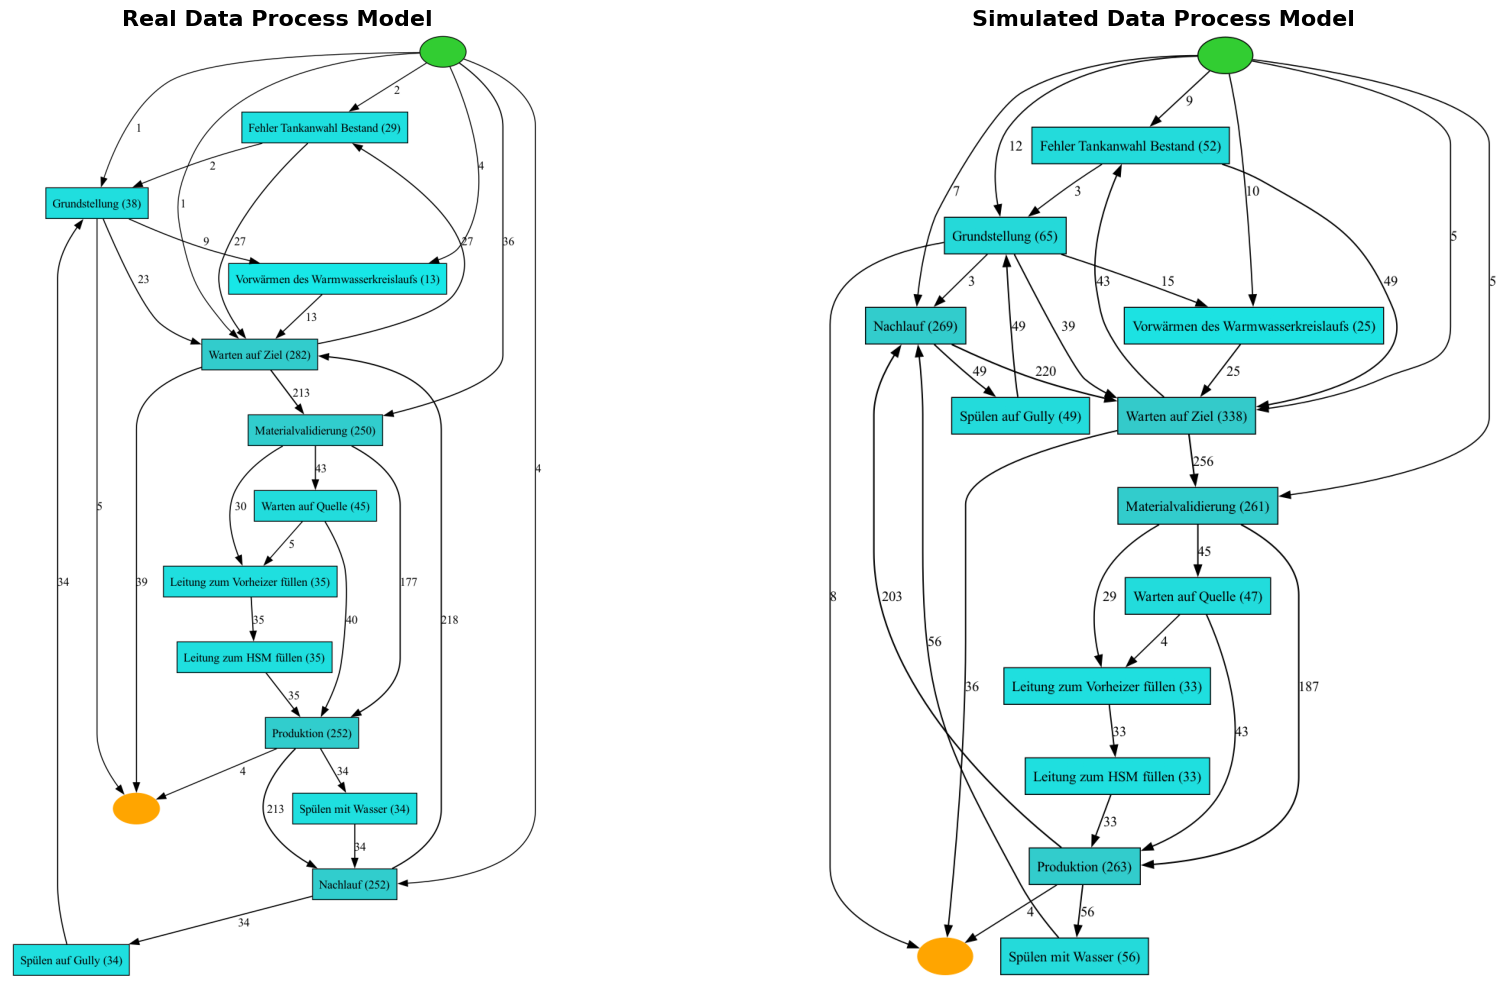

In [33]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tempfile
import os

# Create temporary files for the visualizations
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_real, \
     tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_sim:
    
    temp_real_path = temp_real.name
    temp_sim_path = temp_sim.name

try:
    # Generate and save real data heuristic net
    df_real = df_compare.copy()
    event_log_real = pm4py.format_dataframe(df_real, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
    net_real = pm4py.discover_heuristics_net(event_log_real)
    pm4py.save_vis_heuristics_net(net_real, temp_real_path, bgcolor='white', dpi=500)
    
    # Generate and save simulated data heuristic net
    df_sim = simulated_log.copy()
    event_log_sim = pm4py.format_dataframe(df_sim, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
    net_sim = pm4py.discover_heuristics_net(event_log_sim)
    pm4py.save_vis_heuristics_net(net_sim, temp_sim_path, bgcolor='white', dpi=500)
    
    # Load and display side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Real data on the left
    img_real = mpimg.imread(temp_real_path)
    ax1.imshow(img_real)
    ax1.set_title('Real Data Process Model', fontsize=16, fontweight='bold')
    ax1.axis('off')
    
    # Simulated data on the right
    img_sim = mpimg.imread(temp_sim_path)
    ax2.imshow(img_sim)
    ax2.set_title('Simulated Data Process Model', fontsize=16, fontweight='bold')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
finally:
    # Clean up temporary files
    if os.path.exists(temp_real_path):
        os.unlink(temp_real_path)
    if os.path.exists(temp_sim_path):
        os.unlink(temp_sim_path)

In [34]:
# Debug the simulated log first
print("Simulated log columns:", simulated_log.columns.tolist())
print("Simulated log shape:", simulated_log.shape)
print("\nFirst few rows:")
print(simulated_log.head())
print("\nActivity column type:", type(simulated_log['activity'].iloc[0]))
print("Sample activities:")
print(simulated_log['activity'].value_counts().head(10))

# Check for any problematic data
print("\nAny null values in key columns:")
print("case_id nulls:", simulated_log['case_id'].isnull().sum())
print("activity nulls:", simulated_log['activity'].isnull().sum()) 
print("timestamp_start nulls:", simulated_log['timestamp_start'].isnull().sum())

# Clean the data before creating the process map
df_clean = simulated_log.copy()

# Ensure proper data types
df_clean['case_id'] = df_clean['case_id'].astype(str)
df_clean['activity'] = df_clean['activity'].astype(str)
df_clean['timestamp_start'] = pd.to_datetime(df_clean['timestamp_start'])

# Remove any rows with missing essential data
df_clean = df_clean.dropna(subset=['case_id', 'activity', 'timestamp_start'])

print(f"\nCleaned data shape: {df_clean.shape}")
print("Sample activities after cleaning:")
print(df_clean['activity'].value_counts().head(10))

Simulated log columns: ['case_id', 'activity', 'timestamp_start', 'timestamp_end', 'object', 'object_type', 'higher_level_activity', 'object_attributes']
Simulated log shape: (1491, 8)

First few rows:
              case_id                      activity  \
0  shift_2_2024-11-03     Fehler Tankanwahl Bestand   
1  shift_2_2024-11-03               Warten auf Ziel   
2  shift_2_2024-11-03           Materialvalidierung   
3  shift_2_2024-11-03  Leitung zum Vorheizer füllen   
4  shift_2_2024-11-03        Leitung zum HSM füllen   

             timestamp_start              timestamp_end object  \
0 2024-11-03 15:03:21.000000 2024-11-03 15:15:45.977945    l01   
1 2024-11-03 15:15:46.977945 2024-11-03 16:07:11.962846    l01   
2 2024-11-03 16:07:12.962846 2024-11-03 16:07:18.962846    l01   
3 2024-11-03 16:07:19.962846 2024-11-03 16:10:20.765420    l01   
4 2024-11-03 16:10:21.765420 2024-11-03 16:10:41.785416    l01   

       object_type higher_level_activity  \
0  production_line        

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import jensenshannon
from collections import Counter
import pm4py

def comprehensive_simulation_evaluation(simulated_df, real_df, case_col='case_id', 
                                       activity_col='activity', start_col='timestamp_start', 
                                       end_col='timestamp_end'):
    """
    Comprehensive evaluation of simulation quality based on process mining literature
    
    Metrics based on:
    - Rozinat et al. (2008): Conformance checking of processes based on monitoring real behavior
    - van der Aalst et al. (2010): Process mining manifesto
    - Burattin & Sperduti (2010): Automatic determination of parameters' values for heuristics miner++
    """
    
    results = {}
    
    print("="*80)
    print("COMPREHENSIVE SIMULATION EVALUATION")
    print("="*80)
    
    # ========== 1. BASIC PROCESS METRICS ==========
    print("\n1. BASIC PROCESS METRICS")
    print("-" * 40)
    
    # Event counts
    sim_events = len(simulated_df)
    real_events = len(real_df)
    event_ratio = sim_events / real_events if real_events > 0 else 0
    
    # Case counts  
    sim_cases = simulated_df[case_col].nunique()
    real_cases = real_df[case_col].nunique()
    case_ratio = sim_cases / real_cases if real_cases > 0 else 0
    
    print(f"Events - Real: {real_events}, Sim: {sim_events}, Ratio: {event_ratio:.3f}")
    print(f"Cases - Real: {real_cases}, Sim: {sim_cases}, Ratio: {case_ratio:.3f}")
    
    results['basic_metrics'] = {
        'event_count_ratio': event_ratio,
        'case_count_ratio': case_ratio,
        'event_count_error': abs(1 - event_ratio),
        'case_count_error': abs(1 - case_ratio)
    }
    
    # ========== 2. ACTIVITY FREQUENCY ANALYSIS ==========
    print("\n2. ACTIVITY FREQUENCY ANALYSIS")
    print("-" * 40)
    
    # Activity frequencies
    sim_activity_freq = simulated_df[activity_col].value_counts(normalize=True).sort_index()
    real_activity_freq = real_df[activity_col].value_counts(normalize=True).sort_index()
    
    # Align activities (handle missing activities)
    all_activities = set(sim_activity_freq.index) | set(real_activity_freq.index)
    sim_freq_aligned = pd.Series([sim_activity_freq.get(act, 0) for act in all_activities], index=all_activities)
    real_freq_aligned = pd.Series([real_activity_freq.get(act, 0) for act in all_activities], index=all_activities)
    
    # Jensen-Shannon divergence for activity distributions
    js_divergence = jensenshannon(sim_freq_aligned.values, real_freq_aligned.values)
    
    # Mean Absolute Error of frequencies
    freq_mae = np.mean(np.abs(sim_freq_aligned.values - real_freq_aligned.values))
    
    print(f"Activity Coverage - Real: {len(real_activity_freq)}, Sim: {len(sim_activity_freq)}")
    print(f"Jensen-Shannon Divergence (activities): {js_divergence:.4f} (0=perfect, 1=worst)")
    print(f"Mean Absolute Error (frequencies): {freq_mae:.4f}")
    
    results['activity_metrics'] = {
        'js_divergence': js_divergence,
        'frequency_mae': freq_mae,
        'activity_coverage_ratio': len(sim_activity_freq) / len(real_activity_freq) if len(real_activity_freq) > 0 else 0
    }
    
    # ========== 3. DURATION ANALYSIS ==========
    print("\n3. DURATION ANALYSIS")
    print("-" * 40)
    
    # Calculate durations
    sim_durations = (simulated_df[end_col] - simulated_df[start_col]).dt.total_seconds() / 60
    real_durations = (real_df[end_col] - real_df[start_col]).dt.total_seconds() / 60
    
    # Statistical comparison
    duration_ks_stat, duration_ks_pvalue = stats.ks_2samp(sim_durations, real_durations)
    
    # Duration statistics comparison
    duration_stats = pd.DataFrame({
        'Real': [real_durations.mean(), real_durations.median(), real_durations.std()],
        'Simulated': [sim_durations.mean(), sim_durations.median(), sim_durations.std()],
    }, index=['Mean', 'Median', 'Std'])
    
    duration_stats['Error'] = np.abs(duration_stats['Simulated'] - duration_stats['Real']) / duration_stats['Real']
    
    print("Duration Statistics:")
    print(duration_stats.round(3))
    print(f"\nKolmogorov-Smirnov Test: KS={duration_ks_stat:.4f}, p-value={duration_ks_pvalue:.4f}")
    print(f"(p > 0.05 suggests distributions are similar)")
    
    results['duration_metrics'] = {
        'ks_statistic': duration_ks_stat,
        'ks_pvalue': duration_ks_pvalue,
        'mean_duration_error': duration_stats.loc['Mean', 'Error'],
        'median_duration_error': duration_stats.loc['Median', 'Error'],
        'std_duration_error': duration_stats.loc['Std', 'Error']
    }
    
    # ========== 4. CASE-LEVEL ANALYSIS ==========
    print("\n4. CASE-LEVEL ANALYSIS")
    print("-" * 40)
    
    # Events per case
    sim_events_per_case = simulated_df.groupby(case_col).size()
    real_events_per_case = real_df.groupby(case_col).size()
    
    # Statistical test for events per case
    events_per_case_ks, events_per_case_pvalue = stats.ks_2samp(sim_events_per_case, real_events_per_case)
    
    case_stats = pd.DataFrame({
        'Real': [real_events_per_case.mean(), real_events_per_case.median(), real_events_per_case.std()],
        'Simulated': [sim_events_per_case.mean(), sim_events_per_case.median(), sim_events_per_case.std()],
    }, index=['Mean', 'Median', 'Std'])
    
    case_stats['Error'] = np.abs(case_stats['Simulated'] - case_stats['Real']) / case_stats['Real']
    
    print("Events per Case Statistics:")
    print(case_stats.round(3))
    print(f"\nKS Test (events per case): KS={events_per_case_ks:.4f}, p-value={events_per_case_pvalue:.4f}")
    
    results['case_metrics'] = {
        'events_per_case_ks': events_per_case_ks,
        'events_per_case_pvalue': events_per_case_pvalue,
        'mean_events_per_case_error': case_stats.loc['Mean', 'Error'],
        'median_events_per_case_error': case_stats.loc['Median', 'Error']
    }
    
    # ========== 5. CONTROL-FLOW ANALYSIS ==========
    print("\n5. CONTROL-FLOW ANALYSIS (Directly-Follows Graph)")
    print("-" * 40)
    
    # Create event logs for pm4py
    sim_log = pm4py.format_dataframe(simulated_df, case_id=case_col, activity_key=activity_col, timestamp_key=start_col)
    real_log = pm4py.format_dataframe(real_df, case_id=case_col, activity_key=activity_col, timestamp_key=start_col)
    
    # Discover DFGs
    sim_dfg, sim_start, sim_end = pm4py.discover_dfg(sim_log)
    real_dfg, real_start, real_end = pm4py.discover_dfg(real_log)
    
    # Compare DFG edges
    sim_edges = set(sim_dfg.keys())
    real_edges = set(real_dfg.keys())
    
    edge_precision = len(sim_edges & real_edges) / len(sim_edges) if len(sim_edges) > 0 else 0
    edge_recall = len(sim_edges & real_edges) / len(real_edges) if len(real_edges) > 0 else 0
    edge_f1 = 2 * (edge_precision * edge_recall) / (edge_precision + edge_recall) if (edge_precision + edge_recall) > 0 else 0
    
    print(f"DFG Edges - Real: {len(real_edges)}, Sim: {len(sim_edges)}, Common: {len(sim_edges & real_edges)}")
    print(f"Edge Precision: {edge_precision:.4f}")
    print(f"Edge Recall: {edge_recall:.4f}")
    print(f"Edge F1-Score: {edge_f1:.4f}")
    
    # Compare start/end activities (convert dict keys to sets)
    sim_start_set = set(sim_start.keys())
    real_start_set = set(real_start.keys())
    sim_end_set = set(sim_end.keys())
    real_end_set = set(real_end.keys())
    
    start_jaccard = len(sim_start_set & real_start_set) / len(sim_start_set | real_start_set) if len(sim_start_set | real_start_set) > 0 else 0
    end_jaccard = len(sim_end_set & real_end_set) / len(sim_end_set | real_end_set) if len(sim_end_set | real_end_set) > 0 else 0
    
    print(f"Start Activities Jaccard: {start_jaccard:.4f}")
    print(f"End Activities Jaccard: {end_jaccard:.4f}")
    
    results['control_flow_metrics'] = {
        'edge_precision': edge_precision,
        'edge_recall': edge_recall,
        'edge_f1_score': edge_f1,
        'start_activities_jaccard': start_jaccard,
        'end_activities_jaccard': end_jaccard
    }
    
    # ========== 6. OVERALL QUALITY SCORE ==========
    print("\n6. OVERALL QUALITY ASSESSMENT")
    print("-" * 40)
    
    # Weighted quality score (based on literature importance)
    quality_components = {
        'Event Count': (1 - results['basic_metrics']['event_count_error'], 0.15),
        'Activity Distribution': (1 - results['activity_metrics']['js_divergence'], 0.25),
        'Duration Distribution': (1 - results['duration_metrics']['ks_statistic'], 0.20),
        'Case Structure': (1 - results['case_metrics']['events_per_case_ks'], 0.15),
        'Control Flow': (results['control_flow_metrics']['edge_f1_score'], 0.25)
    }
    
    overall_score = sum(score * weight for (score, weight) in quality_components.values())
    
    print("Quality Components:")
    for component, (score, weight) in quality_components.items():
        print(f"  {component:20}: {score:.4f} (weight: {weight:.2f})")
    print(f"\nOVERALL QUALITY SCORE: {overall_score:.4f} (0=worst, 1=perfect)")
    
    if overall_score >= 0.8:
        quality_assessment = "EXCELLENT"
    elif overall_score >= 0.6:
        quality_assessment = "GOOD"
    elif overall_score >= 0.4:
        quality_assessment = "FAIR"
    else:
        quality_assessment = "POOR"
    
    print(f"QUALITY ASSESSMENT: {quality_assessment}")
    
    results['overall_score'] = overall_score
    results['quality_assessment'] = quality_assessment
    
    return results

🔍 RUNNING COMPREHENSIVE SIMULATION EVALUATION
Based on process mining literature (Rozinat et al., van der Aalst et al., Burattin & Sperduti)
COMPREHENSIVE SIMULATION EVALUATION

1. BASIC PROCESS METRICS
----------------------------------------
Events - Real: 1299, Sim: 1491, Ratio: 1.148
Cases - Real: 48, Sim: 48, Ratio: 1.000

2. ACTIVITY FREQUENCY ANALYSIS
----------------------------------------
Activity Coverage - Real: 12, Sim: 12
Jensen-Shannon Divergence (activities): 0.0583 (0=perfect, 1=worst)
Mean Absolute Error (frequencies): 0.0102

3. DURATION ANALYSIS
----------------------------------------
Duration Statistics:
           Real  Simulated  Error
Mean     23.571     43.829  0.859
Median    0.917      2.175  1.373
Std     151.361    198.989  0.315

Kolmogorov-Smirnov Test: KS=0.2209, p-value=0.0000
(p > 0.05 suggests distributions are similar)

4. CASE-LEVEL ANALYSIS
----------------------------------------
Events per Case Statistics:
          Real  Simulated  Error
Mean  

/var/folders/j7/bzg541gd7dg10j_2qvx3s4j00000gn/T/ipykernel_59471/2201761089.py:49: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/j7/bzg541gd7dg10j_2qvx3s4j00000gn/T/ipykernel_59471/2201761089.py:52: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



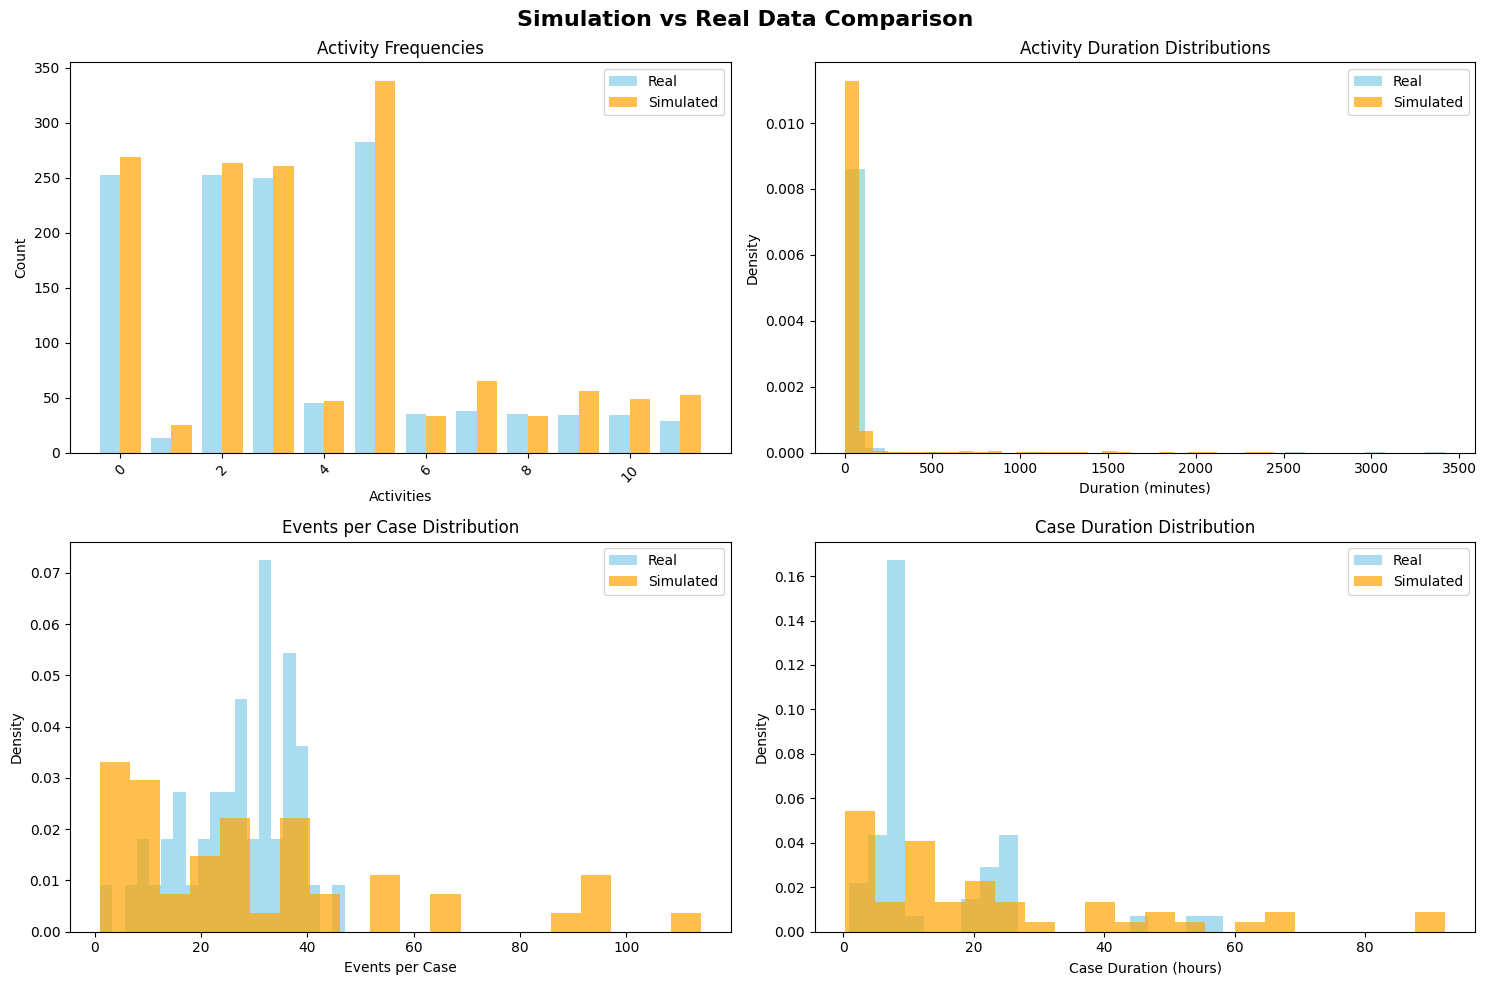

In [36]:
def plot_simulation_comparison(simulated_df, real_df, case_col='case_id', 
                             activity_col='activity', start_col='timestamp_start', 
                             end_col='timestamp_end'):
    """Create detailed comparison plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Simulation vs Real Data Comparison', fontsize=16, fontweight='bold')
    
    # 1. Activity frequencies
    sim_freq = simulated_df[activity_col].value_counts()
    real_freq = real_df[activity_col].value_counts()
    
    all_activities = list(set(sim_freq.index) | set(real_freq.index))
    sim_aligned = [sim_freq.get(act, 0) for act in all_activities]
    real_aligned = [real_freq.get(act, 0) for act in all_activities]
    
    x = np.arange(len(all_activities))
    axes[0,0].bar(x - 0.2, real_aligned, 0.4, label='Real', alpha=0.7, color='skyblue')
    axes[0,0].bar(x + 0.2, sim_aligned, 0.4, label='Simulated', alpha=0.7, color='orange')
    axes[0,0].set_title('Activity Frequencies')
    axes[0,0].set_xlabel('Activities')
    axes[0,0].set_ylabel('Count')
    axes[0,0].legend()
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Duration distributions
    sim_durations = (simulated_df[end_col] - simulated_df[start_col]).dt.total_seconds() / 60
    real_durations = (real_df[end_col] - real_df[start_col]).dt.total_seconds() / 60
    
    axes[0,1].hist(real_durations, alpha=0.7, label='Real', bins=30, density=True, color='skyblue')
    axes[0,1].hist(sim_durations, alpha=0.7, label='Simulated', bins=30, density=True, color='orange')
    axes[0,1].set_title('Activity Duration Distributions')
    axes[0,1].set_xlabel('Duration (minutes)')
    axes[0,1].set_ylabel('Density')
    axes[0,1].legend()
    
    # 3. Events per case
    sim_events_per_case = simulated_df.groupby(case_col).size()
    real_events_per_case = real_df.groupby(case_col).size()
    
    axes[1,0].hist(real_events_per_case, alpha=0.7, label='Real', bins=20, density=True, color='skyblue')
    axes[1,0].hist(sim_events_per_case, alpha=0.7, label='Simulated', bins=20, density=True, color='orange')
    axes[1,0].set_title('Events per Case Distribution')
    axes[1,0].set_xlabel('Events per Case')
    axes[1,0].set_ylabel('Density')
    axes[1,0].legend()
    
    # 4. Cumulative case duration
    sim_case_durations = simulated_df.groupby(case_col).apply(
        lambda x: (x[end_col].max() - x[start_col].min()).total_seconds() / 3600
    )
    real_case_durations = real_df.groupby(case_col).apply(
        lambda x: (x[end_col].max() - x[start_col].min()).total_seconds() / 3600
    )
    
    axes[1,1].hist(real_case_durations, alpha=0.7, label='Real', bins=20, density=True, color='skyblue')
    axes[1,1].hist(sim_case_durations, alpha=0.7, label='Simulated', bins=20, density=True, color='orange')
    axes[1,1].set_title('Case Duration Distribution')
    axes[1,1].set_xlabel('Case Duration (hours)')
    axes[1,1].set_ylabel('Density')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

# Run the comprehensive evaluation
print("🔍 RUNNING COMPREHENSIVE SIMULATION EVALUATION")
print("Based on process mining literature (Rozinat et al., van der Aalst et al., Burattin & Sperduti)")
print("="*80)

evaluation_results = comprehensive_simulation_evaluation(simulated_log, df_final_clean)

print("\n📊 GENERATING COMPARISON PLOTS")
plot_simulation_comparison(simulated_log, df_final_clean)

# Data fusion

In [ ]:
import pandas as pd

def expand_activities_to_timeseries(df_activities, df_energy, energy_cols=None):
    """
    For each activity, filter df_energy to the [timestamp_start, timestamp_end) interval,
    then create rows combining activity info with each energy timestamp's data.
    Append all into one DataFrame, preserving the complete time series per activity.
    """
    if energy_cols is None:
        energy_cols = [col for col in df_energy.columns if col != 'datetime']
    
    expanded_rows = []
    
    for _, activity_row in df_activities.iterrows():
        start = activity_row['timestamp_start_log']
        end = activity_row['timestamp_end_log']
        
        # Filter energy data within the activity's time interval
        mask = (df_energy['datetime_energy'] >= start) & (df_energy['datetime_energy'] < end)
        energy_subset = df_energy.loc[mask, ['datetime_energy'] + energy_cols]
        
        # Create new rows: activity data + each energy row
        for _, energy_row in energy_subset.iterrows():
            new_row = activity_row.to_dict()
            new_row.update(energy_row.to_dict())  # Merge energy data
            expanded_rows.append(new_row)
    
    return pd.DataFrame(expanded_rows)

# Rename columns in df_final_clean to add suffix '_log'
df_activites = df_final_clean.add_suffix('_log')

# Rename columns in df_energy to add prefix '_sen', except 'datetime'
df_energys = df_energy.add_suffix('_energy')

# Usage: Use all sensor columns
df_expanded = expand_activities_to_timeseries(df_activites, df_energys)

# View result
print(df_expanded.head())
print(f"Shape: {df_expanded.shape}")

In [50]:
df_combined

,pro_volstrom_l/h_energy,cip_turm_f__energy,pro_menge_kg_energy,cip_turm_g__energy,pro_power_kW_energy,medium_power_kW_energy,dampfmenge_kg/h_nmb+cip__energy,datetime_energy,pro_temp_out__energy,timestamp_start_log,timestamp_end_log,activity_log,higher_level_activity_log,object_type_log,object_log,case_id_log,object_attributes_log
0,0.000000,0,0.000000,0,0.000000,334.834330,574.001709,2024-11-03 14:03:21,31.201172,2024-11-03 14:03:21,2024-11-04 08:58:21,Grundstellung,shift,production_line,l01,shift_2_2024-11-03,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
13621,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,2024-11-04 08:58:26,31.418186,2024-11-04 08:58:26,2024-11-04 08:59:01,Vorwärmen des Warmwasserkreislaufs,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
13629,0.000000,0,0.000000,0,0.000000,182.080678,312.138306,2024-11-04 08:59:06,31.401909,2024-11-04 08:59:06,2024-11-04 10:13:56,Warten auf Ziel,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
14528,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,2024-11-04 10:14:01,42.654079,2024-11-04 10:14:01,2024-11-04 10:14:06,Materialvalidierung,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
14530,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,2024-11-04 10:14:11,42.643230,2024-11-04 10:14:11,2024-11-04 10:17:41,Leitung zum Vorheizer füllen,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700619,18923.873047,0,474.569550,0,1162.648257,497.504328,852.864563,2024-11-22 19:39:56,60.432941,2024-11-22 19:39:56,2024-11-22 19:43:41,Produktion,shift,production_line,l02,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
700665,20140.289062,0,1753.524048,0,1152.608882,552.149638,946.542236,2024-11-22 19:43:46,56.635201,2024-11-22 19:43:46,2024-11-22 19:46:06,Spülen mit Wasser,shift,production_line,l02,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
700694,10369.801758,0,2163.953125,0,673.703879,578.100886,991.030090,2024-11-22 19:46:11,63.617622,2024-11-22 19:46:11,2024-11-22 19:46:21,Nachlauf,shift,production_line,l02,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
700697,61.678474,0,2194.735107,0,3.999701,142.204376,243.778931,2024-11-22 19:46:26,63.509113,2024-11-22 19:46:26,2024-11-22 19:46:56,Spülen auf Gully,shift,production_line,l02,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."


In [37]:
df_expanded

,pro_volstrom_l/h_energy,cip_turm_f__energy,pro_menge_kg_energy,cip_turm_g__energy,pro_power_kW_energy,medium_power_kW_energy,dampfmenge_kg/h_nmb+cip__energy,datetime_energy,pro_temp_out__energy,timestamp_start_log,timestamp_end_log,activity_log,higher_level_activity_log,object_type_log,object_log,case_id_log,object_attributes_log
0,0.000000,0,0.000000,0,0.000000,334.834330,574.001709,2024-11-03 14:03:21,31.201172,2024-11-03 14:03:21,2024-11-04 08:58:21,Grundstellung,shift,production_line,l01,shift_2_2024-11-03,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
13621,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,2024-11-04 08:58:26,31.418186,2024-11-04 08:58:26,2024-11-04 08:59:01,Vorwärmen des Warmwasserkreislaufs,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
13629,0.000000,0,0.000000,0,0.000000,182.080678,312.138306,2024-11-04 08:59:06,31.401909,2024-11-04 08:59:06,2024-11-04 10:13:56,Warten auf Ziel,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
14528,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,2024-11-04 10:14:01,42.654079,2024-11-04 10:14:01,2024-11-04 10:14:06,Materialvalidierung,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
14530,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,2024-11-04 10:14:11,42.643230,2024-11-04 10:14:11,2024-11-04 10:17:41,Leitung zum Vorheizer füllen,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332258,19536.341797,0,460.978302,0,1237.165844,298.122836,511.067719,2024-11-22 19:50:56,60.709637,2024-11-22 19:50:56,2024-11-22 19:52:51,Produktion,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332282,19942.060547,0,1141.059692,0,1287.209562,338.843074,580.873840,2024-11-22 19:52:56,61.783855,2024-11-22 19:52:56,2024-11-22 19:55:16,Spülen mit Wasser,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332311,10594.337891,0,1576.173096,0,688.868614,0.000000,0.000000,2024-11-22 19:55:21,62.201607,2024-11-22 19:55:21,2024-11-22 19:55:31,Nachlauf,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332314,0.000000,0,1603.361084,0,0.000000,0.000000,0.000000,2024-11-22 19:55:36,57.248264,2024-11-22 19:55:36,2024-11-22 19:56:01,Spülen auf Gully,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."


In [38]:
# Assuming df_expanded is already created from the previous code

# Group by datetime_energy and collect activities
overlaps = df_expanded.groupby('datetime_energy')['activity_log'].apply(list).reset_index()

# Add a column for the number of activities
overlaps['num_activities'] = overlaps['activity_log'].apply(len)

# # Filter for overlaps (more than one activity)
# overlapping = overlaps[overlaps['num_activities'] > 1]

overlaps

,datetime_energy,activity_log,num_activities
0,2024-11-03 14:03:21,[Grundstellung],1
1,2024-11-04 08:58:26,[Vorwärmen des Warmwasserkreislaufs],1
2,2024-11-04 08:59:06,[Warten auf Ziel],1
3,2024-11-04 10:14:01,[Materialvalidierung],1
4,2024-11-04 10:14:11,[Leitung zum Vorheizer füllen],1
...,...,...,...
1294,2024-11-22 19:50:56,[Produktion],1
1295,2024-11-22 19:52:56,[Spülen mit Wasser],1
1296,2024-11-22 19:55:21,[Nachlauf],1
1297,2024-11-22 19:55:36,[Spülen auf Gully],1


In [39]:
df_expanded.columns

Index(['pro_volstrom_l/h_energy', 'cip_turm_f__energy', 'pro_menge_kg_energy',
       'cip_turm_g__energy', 'pro_power_kW_energy', 'medium_power_kW_energy',
       'dampfmenge_kg/h_nmb+cip__energy', 'datetime_energy',
       'pro_temp_out__energy', 'timestamp_start_log', 'timestamp_end_log',
       'activity_log', 'higher_level_activity_log', 'object_type_log',
       'object_log', 'case_id_log', 'object_attributes_log'],
      dtype='object')

In [40]:
df_expanded['activity_log'].unique()

array(['Grundstellung', 'Vorwärmen des Warmwasserkreislaufs',
       'Warten auf Ziel', 'Materialvalidierung',
       'Leitung zum Vorheizer füllen', 'Leitung zum HSM füllen',
       'Produktion', 'Spülen mit Wasser', 'Nachlauf', 'Spülen auf Gully',
       'Fehler Tankanwahl Bestand', 'Warten auf Quelle'], dtype=object)

In [42]:
df_expanded['activity_log'].value_counts().head(20)

activity_log
Warten auf Ziel                       282
Produktion                            252
Nachlauf                              252
Materialvalidierung                   250
Warten auf Quelle                      45
Grundstellung                          38
Leitung zum Vorheizer füllen           35
Leitung zum HSM füllen                 35
Spülen mit Wasser                      34
Spülen auf Gully                       34
Fehler Tankanwahl Bestand              29
Vorwärmen des Warmwasserkreislaufs     13
Name: count, dtype: int64

In [45]:
df_expanded.columns

Index(['pro_volstrom_l/h_energy', 'cip_turm_f__energy', 'pro_menge_kg_energy',
       'cip_turm_g__energy', 'pro_power_kW_energy', 'medium_power_kW_energy',
       'dampfmenge_kg/h_nmb+cip__energy', 'datetime_energy',
       'pro_temp_out__energy', 'timestamp_start_log', 'timestamp_end_log',
       'activity_log', 'higher_level_activity_log', 'object_type_log',
       'object_log', 'case_id_log', 'object_attributes_log'],
      dtype='object')

In [49]:
df_expanded

,pro_volstrom_l/h_energy,cip_turm_f__energy,pro_menge_kg_energy,cip_turm_g__energy,pro_power_kW_energy,medium_power_kW_energy,dampfmenge_kg/h_nmb+cip__energy,datetime_energy,pro_temp_out__energy,timestamp_start_log,timestamp_end_log,activity_log,higher_level_activity_log,object_type_log,object_log,case_id_log,object_attributes_log
0,0.000000,0,0.000000,0,0.000000,334.834330,574.001709,2024-11-03 14:03:21,31.201172,2024-11-03 14:03:21,2024-11-04 08:58:21,Grundstellung,shift,production_line,l01,shift_2_2024-11-03,"{'mat_id_m01_': 0, 'mat_id_m02_': 0, 'mat_id_m..."
13621,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,2024-11-04 08:58:26,31.418186,2024-11-04 08:58:26,2024-11-04 08:59:01,Vorwärmen des Warmwasserkreislaufs,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
13629,0.000000,0,0.000000,0,0.000000,182.080678,312.138306,2024-11-04 08:59:06,31.401909,2024-11-04 08:59:06,2024-11-04 10:13:56,Warten auf Ziel,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681981, 'mat_id_m02_': 0, 'ma..."
14528,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,2024-11-04 10:14:01,42.654079,2024-11-04 10:14:01,2024-11-04 10:14:06,Materialvalidierung,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
14530,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,2024-11-04 10:14:11,42.643230,2024-11-04 10:14:11,2024-11-04 10:17:41,Leitung zum Vorheizer füllen,shift,production_line,l01,shift_1_2024-11-04,"{'mat_id_m01_': 8681982, 'mat_id_m02_': 0, 'ma..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332258,19536.341797,0,460.978302,0,1237.165844,298.122836,511.067719,2024-11-22 19:50:56,60.709637,2024-11-22 19:50:56,2024-11-22 19:52:51,Produktion,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332282,19942.060547,0,1141.059692,0,1287.209562,338.843074,580.873840,2024-11-22 19:52:56,61.783855,2024-11-22 19:52:56,2024-11-22 19:55:16,Spülen mit Wasser,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332311,10594.337891,0,1576.173096,0,688.868614,0.000000,0.000000,2024-11-22 19:55:21,62.201607,2024-11-22 19:55:21,2024-11-22 19:55:31,Nachlauf,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."
332314,0.000000,0,1603.361084,0,0.000000,0.000000,0.000000,2024-11-22 19:55:36,57.248264,2024-11-22 19:55:36,2024-11-22 19:56:01,Spülen auf Gully,shift,production_line,l01,shift_2_2024-11-22,"{'mat_id_m01_': 8842022, 'mat_id_m02_': 0, 'ma..."


In [48]:
import pandas as pd
import plotly.express as px

# Filter and prepare the data from df_expanded
df_plot = df_expanded.copy()
df_plot = df_plot[df_plot['activity_log'].isin(['Produktion'])]  # Adjust activity name if needed based on df_expanded['activity_log'].unique()
df_plot['timestamp_start'] = pd.to_datetime(df_plot['timestamp_start_log'])  # Use the correct column name from df_expanded
#df_plot = df_plot[df_plot['timestamp_start'].dt.date == pd.to_datetime('2024-11-06').date()]  # Adjust date if needed
#df_plot = df_plot.dropna()    
df_plot['type'] = 'actual'
df_plot['activity_type'] = df_plot['activity_log'] + '_actual'  # Use activity_log for consistency

# Plotting with Plotly for one energy feature (e.g., heating_power_energy)
fig = px.line(
    df_plot,
    x='datetime_energy',
    y='pro_volstrom_l/h_energy',  # Changed to an energy feature column from df_expanded
    title='Heating Power Energy Over Time',
    labels={'activity_log'},
    line_shape='linear',
    color='activity_type'
)

# Customize layout
fig.update_layout(
    xaxis_title='Timestamp Start',
    yaxis_title='Heating Power Energy (kW)',
    title_font_size=16,
    xaxis=dict(tickangle=45),  # Rotate x-axis labels
    template='plotly_white'
)

# Show the plot
fig.show()

In [ ]:
df_plot

In [ ]:
df = df_energy.copy()
df['datetime'] = pd.to_datetime(df['datetime'])  # Use the correct column name from df_expanded
df = df[df['datetime'].dt.date == pd.to_datetime('2024-08-14').date()]  # Adjust date if needed

fig = px.line(
    df,
    x='datetime',
    y='flow_Heisswasser_30120FT721(WT5a)_5s',  # Changed to an energy feature column from df_expanded
    title='Heating Power Energy Over Time',
    labels={'activity_log'},
    line_shape='linear',
    #color='activity_type'
)

# Customize layout
fig.update_layout(
    xaxis_title='Timestamp Start',
    yaxis_title='Heating Power Energy (kW)',
    title_font_size=16,
    xaxis=dict(tickangle=45),  # Rotate x-axis labels
    template='plotly_white'
)

# Show the plot
fig.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify columns ending with "_energy"
energy_cols = [col for col in df_expanded.columns if col.endswith('_energy')]

# Set up subplots: calculate rows and columns for grid
n_cols = 3  # Adjust number of columns per row as needed
n_rows = (len(energy_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(energy_cols):
    sns.lineplot(data=df_expanded, x='datetime_energy', y=col, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
df  = df_activites.copy()


df['activity_log'].value_counts()

In [ ]:
df

In [ ]:
df = df_expanded.copy()

# Count unique timestamp_start_log per activity_log (i.e., unique activity instances per activity type)
unique_instances_per_activity = df.groupby('activity_log')['timestamp_start_log'].nunique()

print("Unique activity instances per activity type:")
print(unique_instances_per_activity)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define activities
activities = ['Step-032 = Umlauf', 'Step-030 = Produktion']

# Get all energy columns (excluding datetime_energy)
energy_cols = [col for col in df_expanded.columns if col.endswith('_energy') and col != 'datetime_energy']

print(f"Activities: {activities}")
print(f"Energy variables: {energy_cols}")

for activity in activities:
    print(f"\nProcessing activity: {activity}")
    
    # Filter for this activity
    df_act = df_expanded[df_expanded['activity_log'] == activity].copy()
    
    # Create activity_instance_id
    df_act['activity_instance_id'] = df_act.groupby(['case_id_log', 'activity_log', 'timestamp_start_log']).ngroup()
    
    # Calculate total number of instances for this activity
    total_instances = df_act['activity_instance_id'].nunique()
    print(f"Total number of instances for {activity}: {total_instances}")
    
    # Calculate number of subplots
    n_vars = len(energy_cols)
    n_cols = 3  # Adjust columns per row
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    # Ensure axes is always a flat array
    axes = np.array(axes).flatten()
    
    for i, variable in enumerate(energy_cols):
        if i >= len(axes):
            break  # Safety check
        ax = axes[i]
        
        # Count instances with data for this variable
        instances_with_data = 0
        for instance_id in df_act['activity_instance_id'].unique():
            instance_data = df_act[df_act['activity_instance_id'] == instance_id]
            if instance_data[variable].notna().any():  # At least one non-NaN value
                instances_with_data += 1
        
        print(f"  {variable}: {instances_with_data} instances have data (out of {total_instances})")
        
        # Collect and plot curves for this variable
        curve_count = 0
        for instance_id, group in df_act.groupby('activity_instance_id'):
            group = group.sort_values('datetime_energy')
            # Drop rows where either datetime_energy or variable is NaN
            group = group.dropna(subset=['datetime_energy', variable])
            values = group[variable].values
            times = group['datetime_energy']
            
            if len(values) >= 1 and len(times) >= 1:  # Include curves with at least 1 point
                # Calculate time elapsed in minutes from the start of this instance
                time_elapsed = (times - times.min()).dt.total_seconds() / 60
                
                # Plot the curve
                ax.plot(time_elapsed, values, alpha=0.7, linewidth=1, label=f'Instance {instance_id}')
                curve_count += 1
        
        print(f"  Number of curves plotted for {variable}: {curve_count}")
        
        if curve_count == 0:
            ax.text(0.5, 0.5, f'No valid curves for {variable}', 
                    ha='center', va='center', transform=ax.transAxes)
        
        ax.set_title(f'{variable}')
        ax.set_xlabel('Time (minutes)')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        
        # If too many curves, don't show legend to avoid clutter
        if curve_count > 10:
            ax.legend().set_visible(False)
        elif curve_count > 0:
            ax.legend(fontsize=6, loc='best')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle(f'Complete Energy Curves for Activity: {activity} (All Variables)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
df_expanded

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import optuna  # Assuming optuna is installed

def train_position_based_regression(df_expanded, variable, activities, fixed_length=100, test_size=0.2, random_state=42, 
                                   models=None, optimize_hyperparams=False, n_trials=50):
    """
    Train position-based regression models for energy curve prediction.
    
    Parameters:
    -----------
    df_expanded : pd.DataFrame
        The expanded dataframe with energy data
    variable : str
        The energy variable column name
    activities : list
        List of activity names to include
    fixed_length : int
        Fixed length to resample curves to
    test_size : float
        Proportion of data for testing
    random_state : int
        Random state for reproducibility
    models : dict, optional
        Dictionary of model names to model classes (e.g., {'Gradient Boosting': GradientBoostingRegressor})
        If None, defaults to GradientBoostingRegressor and RandomForestRegressor
    optimize_hyperparams : bool, optional
        Whether to perform hyperparameter optimization with Optuna (default: False)
    n_trials : int, optional
        Number of Optuna trials for optimization (default: 50)
    
    Returns:
    --------
    dict : Results containing models, best model, and metadata
    """
    print("="*80)
    print("POSITION-BASED REGRESSION - NO ERROR COMPOUNDING!")
    print("="*80)
    
    # Default models if not provided
    if models is None:
        models = {
            'Gradient Boosting': GradientBoostingRegressor,
            'Random Forest': RandomForestRegressor
        }
    
    # Prepare data
    df_plot = df_expanded.copy()
    # Select necessary columns including object_attributes_log
    df_plot = df_plot[['case_id_log', 'activity_log', 'timestamp_start_log', 'datetime_energy', variable, 'object_attributes_log']]
    df_plot = df_plot[df_plot['activity_log'].isin(activities)]
    df_plot['timestamp_start'] = pd.to_datetime(df_plot['timestamp_start_log'])
    df_plot['datetime_energy'] = pd.to_datetime(df_plot['datetime_energy'])
    df_plot = df_plot.sort_values(['case_id_log', 'timestamp_start_log', 'datetime_energy'])
    
    # Create instance IDs
    df_plot['activity_instance_id'] = (
        df_plot.groupby(['case_id_log', 'activity_log', 'timestamp_start_log']).ngroup()
    )
    
    # Extract curves and attributes
    curves_data = []
    for instance_id, group in df_plot.groupby('activity_instance_id'):
        group = group.sort_values('datetime_energy').reset_index(drop=True)
        values = group[variable].dropna().values
        
        if len(values) >= 5:
            # Get attributes from the first row (assuming same per instance)
            attributes = group['object_attributes_log'].iloc[0] if not group['object_attributes_log'].empty else {}
            
            curves_data.append({
                'instance_id': instance_id,
                'activity': group['activity_log'].iloc[0],
                'original_values': values,
                'original_length': len(values),
                'attributes': attributes
            })
    
    print(f"\nResampling all curves to fixed length: {fixed_length} points")
    
    # Resample all curves to fixed length
    for curve in curves_data:
        x_old = np.linspace(0, 1, len(curve['original_values']))
        x_new = np.linspace(0, 1, fixed_length)
        curve['resampled_values'] = np.interp(x_new, x_old, curve['original_values'])
    
    print(f"Total curves: {len(curves_data)}")
    
    # Determine attribute columns and types
    if curves_data:
        all_keys = set()
        for curve in curves_data:
            all_keys.update(curve['attributes'].keys())
        all_keys = sorted(all_keys)
        
        # Check convertibility for each key
        key_types = {}
        for key in all_keys:
            is_numeric = True
            for curve in curves_data:
                if key in curve['attributes']:
                    try:
                        float(curve['attributes'][key])
                    except (ValueError, TypeError):
                        is_numeric = False
                        break
            key_types[key] = 'numeric' if is_numeric else 'category'
        
        print(f"Attribute columns: {key_types}")
    else:
        all_keys = []
        key_types = {}
    
    # Build position-based regression dataset
    regression_data = []
    
    for curve in curves_data:
        for position_idx in range(fixed_length):
            # Position as fraction (0 to 1)
            position_fraction = position_idx / (fixed_length - 1) if fixed_length > 1 else 0
            
            row = {
                'instance_id': curve['instance_id'],
                'activity': curve['activity'],
                'position_idx': position_idx,
                'position_fraction': position_fraction,
                'curve_length': curve['original_length'],
                'y': curve['resampled_values'][position_idx]
            }
            
            # Add attributes
            for key in all_keys:
                value = curve['attributes'].get(key, None)
                if key_types[key] == 'numeric':
                    try:
                        row[key] = float(value) if value is not None else np.nan
                    except (ValueError, TypeError):
                        row[key] = np.nan
                else:
                    row[key] = str(value) if value is not None else 'None'
            
            regression_data.append(row)
    
    df_regression = pd.DataFrame(regression_data)
    
    print(f"Regression dataset: {len(df_regression)} samples")
    print(f"  {len(curves_data)} curves × {fixed_length} points")
    
    # Prepare features
    feature_cols = ['position_idx', 'position_fraction', 'curve_length']
    X = df_regression[feature_cols].copy()
    y = df_regression['y'].copy()
    
    # Add activity
    X['activity'] = df_regression['activity']
    
    # Add attributes
    categorical_cols = ['activity']
    for key in all_keys:
        if key_types[key] == 'numeric':
            X[key] = df_regression[key]
        else:
            X[key] = df_regression[key]
            categorical_cols.append(key)
    
    # One-hot encode categorical columns
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    
    # Split by COMPLETE CURVES
    unique_instances = df_regression['instance_id'].unique()
    train_instances, test_instances = train_test_split(
        unique_instances, test_size=test_size, random_state=random_state
    )
    
    train_mask = df_regression['instance_id'].isin(train_instances)
    test_mask = df_regression['instance_id'].isin(test_instances)
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    print(f"\nTrain/Test split:")
    print(f"  Train: {len(train_instances)} curves, {len(X_train)} points")
    print(f"  Test: {len(test_instances)} curves, {len(X_test)} points")
    
    # Train models
    results_position = {}
    
    for name, model_class in models.items():
        print(f"\nTraining {name}...")
        
        if optimize_hyperparams:
            # Define objective function for Optuna
            def objective(trial):
                if name == 'Gradient Boosting':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                        'max_depth': trial.suggest_int('max_depth', 3, 10),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                        'random_state': random_state
                    }
                elif name == 'Random Forest':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                        'max_depth': trial.suggest_int('max_depth', 5, 20),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                        'random_state': random_state,
                        'n_jobs': -1
                    }
                else:
                    # For other models, no hyperparameter optimization defined
                    params = {}
                
                model = model_class(**params)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                return r2_score(y_test, y_pred)
            
            # Run Optuna study
            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=n_trials)
            
            # Get best parameters
            best_params = study.best_params
            if name == 'Gradient Boosting':
                best_params['random_state'] = random_state
            elif name == 'Random Forest':
                best_params['random_state'] = random_state
                best_params['n_jobs'] = -1
            
            print(f"  Best params: {best_params}")
            model = model_class(**best_params)
        else:
            # Use default parameters
            if name == 'Gradient Boosting':
                model = model_class(
                    n_estimators=200, max_depth=7, learning_rate=0.1,
                    subsample=0.8, random_state=random_state
                )
            elif name == 'Random Forest':
                model = model_class(
                    n_estimators=200, max_depth=12, min_samples_split=5,
                    random_state=random_state, n_jobs=-1
                )
            else:
                # For other models, try with random_state, if not supported, without
                try:
                    model = model_class(random_state=random_state)
                except TypeError:
                    model = model_class()
        
        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        results_position[name] = {
            'model': model,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse
        }
        
        print(f"  Train R²={train_r2:.4f}, RMSE={train_rmse:.2f}")
        print(f"  Test R²={test_r2:.4f}, RMSE={test_rmse:.2f}")
    
    # Select best model
    best_model_name_pos = max(results_position.keys(), key=lambda k: results_position[k]['test_r2'])
    best_model_pos = results_position[best_model_name_pos]['model']
    
    print(f"\n✓ Best model: {best_model_name_pos}")
    print(f"  Test R² = {results_position[best_model_name_pos]['test_r2']:.4f}")
    
    # Store for later use
    fixed_curve_length = fixed_length
    feature_columns_pos = X.columns.tolist()
    
    return {
        'results': results_position,
        'best_model': best_model_pos,
        'best_model_name': best_model_name_pos,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_columns': feature_columns_pos,
        'fixed_length': fixed_curve_length,
        'curves_data': curves_data,
        'test_instances': test_instances
    }

def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Calculate comprehensive metrics: MAE, RMSE, WAPE, R²
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Metrics dictionary
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # WAPE (Weighted Absolute Percentage Error)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'WAPE (%)': wape,
        'R²': r2
    }

def display_metrics_table(results_dict, y_test, X_test):
    """
    Display a table of metrics for all models in results_dict
    
    Parameters:
    -----------
    results_dict : dict
        Results from training function
    y_test : array-like
        Test true values
    X_test : pd.DataFrame
        Test features
    """
    metrics_list = []
    
    for model_name, model_info in results_dict['results'].items():
        model = model_info['model']
        y_pred = model.predict(X_test)
        metrics = calculate_metrics(y_test, y_pred, model_name)
        metrics_list.append(metrics)
    
    # Create DataFrame for table
    metrics_df = pd.DataFrame(metrics_list)
    
    # Display table
    print("\n" + "="*80)
    print("MODEL PERFORMANCE METRICS")
    print("="*80)
    print(metrics_df.to_string(index=False, float_format='%.4f'))
    
    # Highlight best model
    best_row = metrics_df.loc[metrics_df['R²'].idxmax()]
    print(f"\n✓ Best model: {best_row['Model']} (R² = {best_row['R²']:.4f})")
    
    return metrics_df

# Example usage:
# training_results = train_position_based_regression(df_expanded, 'flow_Kuehlturmwasser_30120FT701_5s_energy', ['Step-030 = Produktion', 'Step-032 = Umlauf'])
# metrics_table = display_metrics_table(training_results, training_results['y_test'], training_results['X_test'])

# Example with custom models and optimization:
from sklearn.linear_model import LinearRegression
custom_models = {'Linear Regression': LinearRegression, 'Gradient Boosting': GradientBoostingRegressor}
training_results = train_position_based_regression(df_expanded, 'flow_Kuehlturmwasser_30120FT701_5s_energy', ['Step-030 = Produktion', 'Step-032 = Umlauf'], models=custom_models, optimize_hyperparams=False, n_trials=20)

In [ ]:
def explore_energy_curves(activity, variable, df_expanded):
    """
    Explore and visualize energy curves for a specific activity and variable.
    
    Parameters:
    -----------
    activity : str
        The activity name to filter for (e.g., 'Step-032 = Umlauf')
    variable : str
        The energy variable column name (e.g., 'flow_Kuehlturmwasser_30120FT701_5s_energy')
    df_expanded : pd.DataFrame
        The expanded dataframe with energy data
    
    Returns:
    --------
    None : Displays the plot
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    
    print(f"Processing activity: {activity}")
    print(f"Variable: {variable}")
    
    # Filter for this activity
    df_act = df_expanded[df_expanded['activity_log'] == activity].copy()
    
    # Create activity_instance_id
    df_act['activity_instance_id'] = df_act.groupby(['case_id_log', 'activity_log', 'timestamp_start_log']).ngroup()
    
    # Calculate total number of instances for this activity
    total_instances = df_act['activity_instance_id'].nunique()
    print(f"Total number of instances for {activity}: {total_instances}")
    
    # Count instances with data for this variable
    instances_with_data = 0
    for instance_id in df_act['activity_instance_id'].unique():
        instance_data = df_act[df_act['activity_instance_id'] == instance_id]
        if instance_data[variable].notna().any():  # At least one non-NaN value
            instances_with_data += 1
    
    print(f"{variable}: {instances_with_data} instances have data (out of {total_instances})")
    
    # Create a single plot for this variable
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Collect and plot curves for this variable
    curve_count = 0
    for instance_id, group in df_act.groupby('activity_instance_id'):
        group = group.sort_values('datetime_energy')
        # Drop rows where either datetime_energy or variable is NaN
        group = group.dropna(subset=['datetime_energy', variable])
        values = group[variable].values
        times = group['datetime_energy']
        
        if len(values) >= 1 and len(times) >= 1:  # Include curves with at least 1 point
            # Calculate time elapsed in minutes from the start of this instance
            time_elapsed = (times - times.min()).dt.total_seconds() / 60
            
            # Plot the curve
            ax.plot(time_elapsed, values, alpha=0.7, linewidth=1, label=f'Instance {instance_id}')
            curve_count += 1
    
    print(f"Number of curves plotted for {variable}: {curve_count}")
    
    if curve_count == 0:
        ax.text(0.5, 0.5, f'No valid curves for {variable}', 
                ha='center', va='center', transform=ax.transAxes)
    
    ax.set_title(f'{variable} - Original Curves for {activity}')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    
    # If too many curves, don't show legend to avoid clutter
    if curve_count > 10:
        ax.legend().set_visible(False)
    elif curve_count > 0:
        ax.legend(fontsize=6, loc='best')
    
    plt.suptitle(f'Complete Energy Curves for Activity: {activity} ({variable})', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example usage:
explore_energy_curves('Step-032 = Umlauf', 'flow_Kuehlturmwasser_30120FT701_5s_energy', df_expanded)

In [ ]:
a

# Model the energy

In [ ]:
df_plot.columns

In [ ]:
df

In [ ]:
from energy_profile_extractor import EnergyProfileExtractor

# Filter and prepare the data from df_expanded
df_plot = df_expanded.copy()
df_plot = df_plot[df_plot['activity_log'].isin(['Step-032 = Umlauf', 'Step-030 = Produktion'])]  # Adjust activity name if needed based on df_expanded['activity_log'].unique()
df_plot['timestamp_start'] = pd.to_datetime(df_plot['timestamp_start_log'])  # Use the correct column name from df_expanded
df_plot

In [ ]:
variable = 'temp_nach_Erhitzer_(WT5)_5s_energy'

In [ ]:
from energy_profile_extractor import EnergyProfileExtractor

activities = ['Step-032 = Umlauf', 'Step-030 = Produktion']
activities = ['Step-030 = Produktion']

# Filter and prepare the data from df_expanded
df_plot = df_expanded.copy()
df_plot = df_plot[df_plot['activity_log'].isin(activities)]
df_plot['timestamp_start'] = pd.to_datetime(df_plot['timestamp_start_log'])
df_plot['datetime_energy'] = pd.to_datetime(df_plot['datetime_energy'])

df = df_plot.copy()

# CRITICAL: Add start_end markers using datetime_energy (the actual time-series timestamp)
# This ensures consistency with temporal order
df['start_end'] = 'in_between'
for (case_id, activity), group in df.groupby(['case_id_log', 'activity_log']):
    group = group.sort_values('datetime_energy')  # Sort by actual energy timestamp
    df.loc[group.index[0], 'start_end'] = 'start'
    df.loc[group.index[-1], 'start_end'] = 'end'

# Data quality check
print(f"Total rows: {len(df)}")
print(f"Unique case_id: {df['case_id_log'].nunique()}")
print(f"Unique activities: {df['activity_log'].nunique()}")
print(f"Start markers: {(df['start_end'] == 'start').sum()}")
print(f"End markers: {(df['start_end'] == 'end').sum()}")
print(f"NaN in value column: {df[variable].isna().sum()}")

# Initialize the extractor - USE datetime_energy as timestamp for consistency!
extractor = EnergyProfileExtractor(
    value_column=variable,
    case_id_column='case_id_log',
    activity_column='activity_log',
    start_end_column='start_end',
    timestamp_column='datetime_energy',  # Changed to match sorting column
    verbose=True
)

# Fit on training data
print("\n" + "="*60)
print("TRAINING ENERGY PROFILE MODELS")
print("="*60)
results_df = extractor.fit(df)
results_df

In [ ]:
# DIAGNOSTIC: Check data structure before modeling
print("="*60)
print("DATA STRUCTURE DIAGNOSTIC")
print("="*60)

# Check basic structure
print(f"\nTotal rows in df_expanded: {len(df_expanded)}")
print(f"Unique case_ids: {df_expanded['case_id_log'].nunique()}")
print(f"Unique activities: {df_expanded['activity_log'].nunique()}")

# Filter to just the activity we're analyzing
activities = ['Step-030 = Produktion']
df_diagnostic = df_expanded[df_expanded['activity_log'].isin(activities)].copy()

print(f"\nAfter filtering to {activities}:")
print(f"Total rows: {len(df_diagnostic)}")
print(f"Unique case_ids: {df_diagnostic['case_id_log'].nunique()}")

# Check how many energy time-series points per case_id + activity
points_per_case = df_diagnostic.groupby(['case_id_log', 'activity_log']).size()
print(f"\nTime-series points per (case_id, activity) instance:")
print(f"  Min: {points_per_case.min()}")
print(f"  Max: {points_per_case.max()}")
print(f"  Mean: {points_per_case.mean():.1f}")
print(f"  Median: {points_per_case.median():.1f}")

# Check a sample case
sample_case = df_diagnostic['case_id_log'].iloc[0]
sample_data = df_diagnostic[df_diagnostic['case_id_log'] == sample_case].copy()
sample_data = sample_data.sort_values('datetime_energy')

print(f"\nSample case_id '{sample_case}':")
print(f"  Number of energy timestamps: {len(sample_data)}")
print(f"  Time range: {sample_data['datetime_energy'].min()} to {sample_data['datetime_energy'].max()}")
print(f"  Duration: {(sample_data['datetime_energy'].max() - sample_data['datetime_energy'].min()).total_seconds() / 60:.1f} minutes")

# Check for NaN values in energy variables
nan_count = df_diagnostic[variable].isna().sum()
nan_pct = (nan_count / len(df_diagnostic)) * 100
print(f"\nNaN values in '{variable}':")
print(f"  Count: {nan_count} ({nan_pct:.1f}%)")

# Check energy value statistics
print(f"\nEnergy value statistics for '{variable}':")
print(df_diagnostic[variable].describe())

# WARNING: Check if timestamps are properly aligned
print(f"\nTimestamp alignment check:")
print(f"  timestamp_start_log dtype: {df_diagnostic['timestamp_start_log'].dtype}")
print(f"  datetime_energy dtype: {df_diagnostic['datetime_energy'].dtype}")

# Show first few rows with key columns
print(f"\nFirst 10 rows of sample case:")
display(sample_data[['case_id_log', 'activity_log', 'timestamp_start_log', 
                      'timestamp_end_log', 'datetime_energy', variable]].head(10))

In [ ]:
# DIAGNOSTIC: Check start_end marker assignment
print("="*60)
print("START_END MARKER DIAGNOSTIC")
print("="*60)

activities = ['Step-030 = Produktion']

# Prepare data
df_plot = df_expanded.copy()
df_plot = df_plot[df_plot['activity_log'].isin(activities)]
df_plot['timestamp_start'] = pd.to_datetime(df_plot['timestamp_start_log'])
df_plot['datetime_energy'] = pd.to_datetime(df_plot['datetime_energy'])

df = df_plot.copy()

# Add start_end markers
df['start_end'] = 'in_between'
for (case_id, activity), group in df.groupby(['case_id_log', 'activity_log']):
    group = group.sort_values('datetime_energy')
    df.loc[group.index[0], 'start_end'] = 'start'
    df.loc[group.index[-1], 'start_end'] = 'end'

# Check marker distribution
print(f"\nStart_end marker distribution:")
print(df['start_end'].value_counts())

# Check a few sample cases
print(f"\n{'='*60}")
print("Sample case_id analysis:")
print(f"{'='*60}")

unique_cases = df['case_id_log'].unique()[:3]  # Check first 3 cases

for case_id in unique_cases:
    case_data = df[df['case_id_log'] == case_id].sort_values('datetime_energy')
    
    print(f"\nCase ID: {case_id}")
    print(f"  Total energy timestamps: {len(case_data)}")
    print(f"  Start markers: {(case_data['start_end'] == 'start').sum()}")
    print(f"  End markers: {(case_data['start_end'] == 'end').sum()}")
    print(f"  In-between markers: {(case_data['start_end'] == 'in_between').sum()}")
    
    # Show first and last few rows
    print(f"\n  First 3 timestamps:")
    display(case_data[['datetime_energy', 'start_end', variable]].head(3))
    
    print(f"\n  Last 3 timestamps:")
    display(case_data[['datetime_energy', 'start_end', variable]].tail(3))
    
    # Check for issues
    if (case_data['start_end'] == 'start').sum() != 1:
        print(f"  ⚠️ WARNING: Should have exactly 1 'start' marker!")
    if (case_data['start_end'] == 'end').sum() != 1:
        print(f"  ⚠️ WARNING: Should have exactly 1 'end' marker!")
    if len(case_data) < 3:
        print(f"  ⚠️ WARNING: Very short curve (< 3 points)!")

# Check for data quality issues
print(f"\n{'='*60}")
print("DATA QUALITY CHECKS:")
print(f"{'='*60}")
print(f"Total rows: {len(df)}")
print(f"Unique case_id: {df['case_id_log'].nunique()}")
print(f"Unique activities: {df['activity_log'].nunique()}")
print(f"Start markers: {(df['start_end'] == 'start').sum()}")
print(f"End markers: {(df['start_end'] == 'end').sum()}")
print(f"NaN in value column: {df[variable].isna().sum()} ({df[variable].isna().sum() / len(df) * 100:.1f}%)")
print(f"\nExpected: start markers == end markers == unique case_id count")
print(f"Actual: {(df['start_end'] == 'start').sum()} == {(df['start_end'] == 'end').sum()} == {df['case_id_log'].nunique()}")

if (df['start_end'] == 'start').sum() != df['case_id_log'].nunique():
    print("\n⚠️ MISMATCH DETECTED! This will cause problems with curve extraction!")

## 🔧 Potential Issues and Fixes

Based on the diagnostics above, here are common issues and their solutions:

### Issue 1: Overlapping Activities
If you have multiple occurrences of the same activity for the same case_id (e.g., the activity happens multiple times), you need to create a unique identifier for each activity instance.

### Issue 2: Too Few or Too Many Energy Points
- If curves have < 3 points, they'll be skipped
- If there's too much variation in curve lengths, the model may struggle

### Issue 3: NaN Values
- If > 50% of values in a curve are NaN, the curve is skipped
- Make sure energy data is properly aligned with activity timestamps

### Issue 4: Timestamp Misalignment
- `timestamp_start_log` and `timestamp_end_log` define the activity boundaries
- `datetime_energy` should fall within these boundaries
- If energy timestamps don't align, curves will be empty or truncated

In [ ]:
# IMPROVED VERSION: Enhanced energy modeling with better data handling
from energy_profile_extractor import EnergyProfileExtractor


activities = ['Step-030 = Produktion']

# Filter and prepare the data
df_plot = df_expanded.copy()
df_plot = df_plot[df_plot['activity_log'].isin(activities)]
df_plot['timestamp_start'] = pd.to_datetime(df_plot['timestamp_start_log'])
df_plot['datetime_energy'] = pd.to_datetime(df_plot['datetime_energy'])

# CRITICAL FIX: Create unique activity instance IDs
# This handles cases where the same activity occurs multiple times for one case_id
print("Creating unique activity instance IDs...")
df_plot = df_plot.sort_values(['case_id_log', 'timestamp_start_log', 'datetime_energy'])

# Create a unique instance ID for each distinct (case_id, activity, timestamp_start) combination
df_plot['activity_instance_id'] = (
    df_plot.groupby(['case_id_log', 'activity_log', 'timestamp_start_log'])
    .ngroup()
    .astype(str)
)

# Also create a more readable instance name
df_plot['instance_name'] = (
    df_plot['case_id_log'].astype(str) + '_' + 
    df_plot['activity_log'].astype(str) + '_' +
    df_plot.groupby(['case_id_log', 'activity_log']).cumcount().astype(str)
)

df = df_plot.copy()

# Add start_end markers using the unique instance ID
df['start_end'] = 'in_between'
for instance_id, group in df.groupby('activity_instance_id'):
    group = group.sort_values('datetime_energy')
    if len(group) >= 3:  # Only process groups with at least 3 points
        df.loc[group.index[0], 'start_end'] = 'start'
        df.loc[group.index[-1], 'start_end'] = 'end'
    else:
        # Mark short curves for removal
        df.loc[group.index, 'start_end'] = 'too_short'

# Remove curves that are too short
df = df[df['start_end'] != 'too_short']

# Data quality report
print("\n" + "="*60)
print("ENHANCED DATA QUALITY REPORT")
print("="*60)
print(f"Total rows (energy timestamps): {len(df)}")
print(f"Unique case_ids: {df['case_id_log'].nunique()}")
print(f"Unique activities: {df['activity_log'].nunique()}")
print(f"Unique activity instances: {df['activity_instance_id'].nunique()}")
print(f"Start markers: {(df['start_end'] == 'start').sum()}")
print(f"End markers: {(df['start_end'] == 'end').sum()}")
print(f"In-between markers: {(df['start_end'] == 'in_between').sum()}")
print(f"NaN in value column: {df[variable].isna().sum()} ({df[variable].isna().sum() / len(df) * 100:.1f}%)")

# Check points per curve
points_per_curve = df.groupby('activity_instance_id').size()
print(f"\nPoints per activity instance curve:")
print(f"  Min: {points_per_curve.min()}")
print(f"  Max: {points_per_curve.max()}")
print(f"  Mean: {points_per_curve.mean():.1f}")
print(f"  Median: {points_per_curve.median():.1f}")

# Validate: starts == ends == unique instances
is_valid = (
    (df['start_end'] == 'start').sum() == 
    (df['start_end'] == 'end').sum() == 
    df['activity_instance_id'].nunique()
)
print(f"\n✓ Data validation: {'PASSED' if is_valid else 'FAILED'}")

if not is_valid:
    print("⚠️ WARNING: Data structure issues detected!")
    print(f"  Expected starts = ends = instances")
    print(f"  Got: {(df['start_end'] == 'start').sum()} starts, {(df['start_end'] == 'end').sum()} ends, {df['activity_instance_id'].nunique()} instances")
else:
    # Initialize the extractor with the unique instance ID as case_id
    print("\n" + "="*60)
    print("TRAINING ENERGY PROFILE MODELS")
    print("="*60)
    
    extractor = EnergyProfileExtractor(
        value_column=variable,
        case_id_column='activity_instance_id',  # Use unique instance ID
        activity_column='activity_log',
        start_end_column='start_end',
        timestamp_column='datetime_energy',
        verbose=True
    )
    
    # Fit on training data
    try:
        results_df = extractor.fit(df)
        display(results_df)
    except Exception as e:
        print(f"\n⚠️ ERROR during fitting: {e}")
        print("\nShowing first few rows of problematic data:")
        display(df[['activity_instance_id', 'activity_log', 'datetime_energy', 
                    'start_end', variable]].head(20))

In [ ]:
# DEEP DIAGNOSTIC: Analyze extracted curves and model inputs
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("DEEP DIAGNOSTIC: INVESTIGATING POOR MODEL PERFORMANCE")
print("="*80)

# 1. Analyze the extracted curves
print("\n1. ANALYZING EXTRACTED CURVES")
print("-" * 60)

if hasattr(extractor, 'curves_') and extractor.curves_:
    curves = extractor.curves_
    
    print(f"Total curves extracted: {len(curves)}")
    print(f"Target resampled length: {extractor.target_length_}")
    
    # Analyze curve statistics
    curve_lengths_original = []
    curve_means = []
    curve_stds = []
    curve_mins = []
    curve_maxs = []
    
    for curve in curves:
        values = curve['values']
        curve_means.append(np.mean(values))
        curve_stds.append(np.std(values))
        curve_mins.append(np.min(values))
        curve_maxs.append(np.max(values))
    
    print(f"\nCurve value statistics (after resampling to {extractor.target_length_} points):")
    print(f"  Mean values across curves: min={min(curve_means):.2f}, max={max(curve_means):.2f}, avg={np.mean(curve_means):.2f}")
    print(f"  Std values across curves: min={min(curve_stds):.2f}, max={max(curve_stds):.2f}, avg={np.mean(curve_stds):.2f}")
    print(f"  Overall value range: {min(curve_mins):.2f} to {max(curve_maxs):.2f}")
    
    # Check for problematic patterns
    zero_std_curves = sum(1 for std in curve_stds if std < 0.01)
    identical_curves = sum(1 for mean in curve_means if abs(mean - curve_means[0]) < 0.01)
    
    print(f"\nPotential issues:")
    print(f"  Flat curves (std < 0.01): {zero_std_curves}")
    print(f"  Nearly identical mean values: {identical_curves}")
    
    # Visualize sample curves
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Diagnostic: Extracted Energy Curves', fontsize=16, fontweight='bold')
    
    # Plot 1: First 10 curves
    ax1 = axes[0, 0]
    for i, curve in enumerate(curves[:10]):
        ax1.plot(curve['values'], alpha=0.7, label=f'Curve {i+1}')
    ax1.set_title(f'First 10 Curves (Resampled to {extractor.target_length_} points)')
    ax1.set_xlabel('Time Index')
    ax1.set_ylabel('Energy Value')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distribution of mean values
    ax2 = axes[0, 1]
    ax2.hist(curve_means, bins=30, edgecolor='black', alpha=0.7)
    ax2.set_title('Distribution of Curve Mean Values')
    ax2.set_xlabel('Mean Energy Value')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Distribution of std values
    ax3 = axes[1, 0]
    ax3.hist(curve_stds, bins=30, edgecolor='black', alpha=0.7, color='orange')
    ax3.set_title('Distribution of Curve Std Values')
    ax3.set_xlabel('Std Deviation')
    ax3.set_ylabel('Frequency')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Value range analysis
    ax4 = axes[1, 1]
    ax4.scatter(curve_means, curve_stds, alpha=0.6)
    ax4.set_title('Mean vs Std of Each Curve')
    ax4.set_xlabel('Mean Value')
    ax4.set_ylabel('Std Deviation')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Check the regression dataset
    print("\n2. ANALYZING REGRESSION DATASET")
    print("-" * 60)
    
    # Create the dataframe that the model sees
    from energy_profile_extractor import EnergyProfileExtractor
    df_model = extractor._curves_to_dataframe(curves)
    
    print(f"Regression dataset shape: {df_model.shape}")
    print(f"Columns: {df_model.columns.tolist()}")
    print(f"\nTarget variable (y) statistics:")
    print(df_model['y'].describe())
    
    print(f"\nFeature statistics:")
    print(f"  curve_index: min={df_model['curve_index'].min()}, max={df_model['curve_index'].max()}")
    print(f"  Unique activities: {df_model[extractor.activity_column].nunique()}")
    
    # Check for issues
    print(f"\nData quality checks:")
    print(f"  NaN values in y: {df_model['y'].isna().sum()}")
    print(f"  Infinite values in y: {np.isinf(df_model['y']).sum()}")
    print(f"  Zero values in y: {(df_model['y'] == 0).sum()}")
    print(f"  Constant y values: {df_model['y'].nunique() == 1}")
    
    # Check variance
    print(f"\nVariance analysis:")
    print(f"  Y variance: {df_model['y'].var():.4f}")
    print(f"  Y range: [{df_model['y'].min():.2f}, {df_model['y'].max():.2f}]")
    
    # 3. Visualize the regression problem
    print("\n3. VISUALIZING THE REGRESSION PROBLEM")
    print("-" * 60)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle('Diagnostic: Regression Problem Visualization', fontsize=16, fontweight='bold')
    
    # Plot: curve_index vs y for a sample of curves
    ax1 = axes[0]
    sample_curves = df_model['curve_id'].unique()[:5]
    for curve_id in sample_curves:
        curve_data = df_model[df_model['curve_id'] == curve_id]
        ax1.plot(curve_data['curve_index'], curve_data['y'], alpha=0.7, marker='o', markersize=3, label=f'Curve {curve_id}')
    ax1.set_title('Sample Curves: curve_index vs y')
    ax1.set_xlabel('Curve Index (time step)')
    ax1.set_ylabel('y (energy value)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot: Distribution of y values
    ax2 = axes[1]
    ax2.hist(df_model['y'], bins=50, edgecolor='black', alpha=0.7)
    ax2.set_title('Distribution of Target Variable (y)')
    ax2.set_xlabel('y (energy value)')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ No curves extracted yet. Run the extractor.fit() method first.")

print("\n" + "="*80)
print("DIAGNOSTIC COMPLETE")
print("="*80)

In [ ]:
df_expanded

In [ ]:
# FIXED APPROACH 1: NO DATA LEAKAGE - Realistic Curve Generation
# Only use features available BEFORE/DURING curve generation

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

print("="*80)
print("APPROACH 1 FIXED: NO DATA LEAKAGE - AUTOREGRESSIVE GENERATION")
print("="*80)
print("Only using features available at simulation time!")


activities = ['Step-030 = Produktion']

df_plot = df_expanded.copy()
df_plot = df_plot[df_plot['activity_log'].isin(activities)]
df_plot['timestamp_start'] = pd.to_datetime(df_plot['timestamp_start_log'])
df_plot['datetime_energy'] = pd.to_datetime(df_plot['datetime_energy'])
df_plot = df_plot.sort_values(['case_id_log', 'timestamp_start_log', 'datetime_energy'])

# Create unique instance IDs
df_plot['activity_instance_id'] = (
    df_plot.groupby(['case_id_log', 'activity_log', 'timestamp_start_log'])
    .ngroup()
)

# Build features WITHOUT data leakage
enhanced_data = []

for instance_id, group in df_plot.groupby('activity_instance_id'):
    group = group.sort_values('datetime_energy').reset_index(drop=True)
    values = group[variable].dropna().values
    
    if len(values) >= 5:  # Minimum for meaningful features
        for i in range(len(values)):
            # Normalized position in curve (0 to 1)
            normalized_pos = i / (len(values) - 1) if len(values) > 1 else 0
            
            # ONLY USE FEATURES AVAILABLE AT PREDICTION TIME
            features = {
                'instance_id': instance_id,
                'activity': group['activity_log'].iloc[0],
                
                # ✓ Position features (known during generation)
                'norm_index': normalized_pos,  # Where we are (0-1)
                'remaining_ratio': 1 - normalized_pos,  # How much is left
                
                # ✓ Curve length (estimated duration is known)
                'total_length': len(values),
                'log_total_length': np.log1p(len(values)),
                
                # ✓ Autoregressive features (values generated so far)
                'value_lag1': values[i-1] if i > 0 else 0,
                'value_lag2': values[i-2] if i > 1 else 0,
                'value_lag3': values[i-3] if i > 2 else 0,
                'value_lag5': values[i-5] if i > 4 else 0,
                
                # ✓ Cumulative statistics (computed from values BEFORE current point)
                'cumsum': np.sum(values[:i]) if i > 0 else 0,
                'cummean': np.mean(values[:i]) if i > 0 else 0,
                'cumstd': np.std(values[:i]) if i > 1 else 0,
                'cummin': np.min(values[:i]) if i > 0 else 0,
                'cummax': np.max(values[:i]) if i > 0 else 0,
                
                # ✓ Local trends (from history - NOT including current)
                'diff_lag1': values[i-1] - values[i-2] if i > 1 else 0,
                'diff_lag2': values[i-2] - values[i-3] if i > 2 else 0,
                'acceleration': (values[i-1] - values[i-2]) - (values[i-2] - values[i-3]) if i > 2 else 0,
                
                # ✓ Rolling statistics (from history - NOT including current)
                'rolling_mean_3': np.mean(values[max(0,i-3):i]) if i > 0 else 0,
                'rolling_std_3': np.std(values[max(0,i-3):i]) if i > 2 else 0,
                'rolling_mean_5': np.mean(values[max(0,i-5):i]) if i > 0 else 0,
                'rolling_max_5': np.max(values[max(0,i-5):i]) if i > 0 else 0,
                'rolling_min_5': np.min(values[max(0,i-5):i]) if i > 0 else 0,
                
                # ✓ Interaction features
                'pos_x_lag1': normalized_pos * (values[i-1] if i > 0 else 0),
                'pos_x_cummean': normalized_pos * (np.mean(values[:i]) if i > 0 else 0),
                
                # ❌ REMOVED: curve_mean, curve_std, curve_min, curve_max, curve_range
                # These use future information not available at generation time!
                
                # Target
                'y': values[i]
            }
            
            enhanced_data.append(features)

df_enhanced = pd.DataFrame(enhanced_data)

print(f"\nCreated LEAK-FREE enhanced dataset:")
print(f"  Total samples: {len(df_enhanced)}")
print(f"  Unique instances: {df_enhanced['instance_id'].nunique()}")
print(f"  Feature columns: {len([c for c in df_enhanced.columns if c not in ['instance_id', 'activity', 'y']])}")

# Prepare features and target
feature_cols = [c for c in df_enhanced.columns if c not in ['instance_id', 'activity', 'y']]
X = df_enhanced[feature_cols].copy()
y = df_enhanced['y'].copy()

# Add activity as categorical
X['activity'] = df_enhanced['activity']
X = pd.get_dummies(X, columns=['activity'], drop_first=True)

print(f"\nFinal feature matrix shape: {X.shape}")

# CRITICAL: Split by instance to prevent leakage
unique_instances = df_enhanced['instance_id'].unique()
train_instances, test_instances = train_test_split(unique_instances, test_size=0.2, random_state=42)

train_mask = df_enhanced['instance_id'].isin(train_instances)
test_mask = df_enhanced['instance_id'].isin(test_instances)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\nTrain/Test split (by instance):")
print(f"  Train: {len(train_instances)} instances, {len(X_train)} samples")
print(f"  Test: {len(test_instances)} instances, {len(X_test)} samples")

# Train models
print("\n" + "="*60)
print("TRAINING MODELS (NO LEAKAGE)")
print("="*60)

models = {
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }
    
    print(f"  Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")
    
    # Check for overfitting
    r2_diff = train_r2 - test_r2
    if r2_diff > 0.2:
        print(f"  ⚠️ Warning: Overfitting detected (R² gap: {r2_diff:.3f})")
    
    if test_r2 > 0.7:
        print(f"  ✓ Excellent performance!")
    elif test_r2 > 0.5:
        print(f"  ✓ Good performance!")
    elif test_r2 > 0.3:
        print(f"  ⚠️ Moderate performance")
    else:
        print(f"  ❌ Poor performance - may need more features or different approach")

# Show feature importance for best model
best_model_name = max(results.keys(), key=lambda k: results[k]['test_r2'])
best_model = results[best_model_name]['model']

print(f"\n" + "="*60)
print(f"FEATURE IMPORTANCE ({best_model_name})")
print("="*60)

if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 most important features:")
    display(importance_df.head(15))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Feature importance
    axes[0].barh(importance_df['feature'][:15][::-1], importance_df['importance'][:15][::-1])
    axes[0].set_xlabel('Importance')
    axes[0].set_title('Top 15 Feature Importances')
    axes[0].grid(True, alpha=0.3)
    
    # Predictions vs actual
    axes[1].scatter(y_test, results[best_model_name]['predictions'], alpha=0.5, s=1)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual Energy')
    axes[1].set_ylabel('Predicted Energy')
    axes[1].set_title(f'Predictions vs Actual (Test Set)\nR² = {results[best_model_name]["test_r2"]:.4f}')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize AUTOREGRESSIVE curve generation
print("\n" + "="*60)
print("AUTOREGRESSIVE CURVE GENERATION (Test Set)")
print("="*60)
print("Simulating realistic curve generation point-by-point")

test_instance_ids = df_enhanced[test_mask]['instance_id'].unique()[:4]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, instance_id in enumerate(test_instance_ids):
    instance_mask = df_enhanced['instance_id'] == instance_id
    instance_data = df_enhanced[instance_mask].reset_index(drop=True)
    
    y_actual = instance_data['y'].values
    
    # Autoregressive prediction (generate point-by-point)
    y_generated = []
    
    for i in range(len(instance_data)):
        # Build features for current point using only past generated values
        row_features = instance_data.iloc[i][feature_cols].copy()
        
        # Update autoregressive features with generated values (not actual)
        if i > 0:
            row_features['value_lag1'] = y_generated[-1]
            row_features['cumsum'] = np.sum(y_generated)
            row_features['cummean'] = np.mean(y_generated)
            row_features['cumstd'] = np.std(y_generated) if i > 1 else 0
            row_features['cummin'] = np.min(y_generated)
            row_features['cummax'] = np.max(y_generated)
            row_features['pos_x_lag1'] = row_features['norm_index'] * y_generated[-1]
            row_features['pos_x_cummean'] = row_features['norm_index'] * np.mean(y_generated)
            row_features['rolling_mean_3'] = np.mean(y_generated[-3:]) if len(y_generated) >= 1 else 0
            row_features['rolling_std_3'] = np.std(y_generated[-3:]) if len(y_generated) >= 3 else 0
            row_features['rolling_mean_5'] = np.mean(y_generated[-5:]) if len(y_generated) >= 1 else 0
            row_features['rolling_max_5'] = np.max(y_generated[-5:]) if len(y_generated) >= 1 else 0
            row_features['rolling_min_5'] = np.min(y_generated[-5:]) if len(y_generated) >= 1 else 0
        
        if i > 1:
            row_features['value_lag2'] = y_generated[-2]
            row_features['diff_lag1'] = y_generated[-1] - y_generated[-2]
        
        if i > 2:
            row_features['diff_lag2'] = y_generated[-2] - y_generated[-3]
            row_features['acceleration'] = (y_generated[-1] - y_generated[-2]) - (y_generated[-2] - y_generated[-3])
        
        if i > 2:
            row_features['value_lag3'] = y_generated[-3]
        
        if i > 4:
            row_features['value_lag5'] = y_generated[-5]
        
        # Add activity encoding
        activity_val = instance_data.iloc[i]['activity']
        for col in X.columns:
            if col.startswith('activity_'):
                row_features[col] = 1 if col == f'activity_{activity_val}' else 0
        
        # Predict next point
        X_pred = pd.DataFrame([row_features])[X.columns]
        y_pred = best_model.predict(X_pred)[0]
        y_generated.append(y_pred)
    
    y_generated = np.array(y_generated)
    
    # Calculate R² for this curve
    curve_r2 = r2_score(y_actual, y_generated)
    
    axes[idx].plot(y_actual, label='Actual', linewidth=2, marker='o', markersize=4, alpha=0.7)
    axes[idx].plot(y_generated, label='Generated (Autoregressive)', linewidth=2, 
                   marker='s', markersize=4, alpha=0.7, linestyle='--')
    axes[idx].set_title(f'Instance {instance_id} (R²={curve_r2:.3f})')
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Energy Value')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Autoregressive Energy Curve Generation (Test Set)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FIXED APPROACH 1 SUMMARY")
print("="*80)
print(f"Best model: {best_model_name}")
print(f"  Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"  Test RMSE: {results[best_model_name]['test_rmse']:.2f}")

print("\n✓ This R² is REALISTIC because:")
print("  - No global curve statistics used")
print("  - Only features available at simulation time")
print("  - Train/test split by instance")
print("  - Autoregressive generation tested")

if results[best_model_name]['test_r2'] > 0.5:
    print("\n✓ Model is ready for simulation!")
    print("  You can generate realistic energy curves point-by-point")
elif results[best_model_name]['test_r2'] > 0.3:
    print("\n⚠️ Moderate performance - usable but could be improved")
    print("  Consider adding more process features (product type, batch size, etc.)")
else:
    print("\n⚠️ Poor performance - need more information")
    print("  Try: Approach 2 (Fourier), add process parameters, or use historical curves")

In [ ]:
# DIAGNOSTIC: Compare Test Set Performance vs Autoregressive Performance

print("="*80)
print("CRITICAL DIAGNOSTIC: FINDING THE REAL R²")
print("="*80)

# VERIFICATION: Confirm we're using complete curves for train/test
train_instance_ids = df_enhanced[train_mask]['instance_id'].unique()
test_instance_ids = df_enhanced[test_mask]['instance_id'].unique()

print("\n✅ TRAIN/TEST SPLIT VERIFICATION:")
print(f"   Training curves (instances): {len(train_instance_ids)}")
print(f"   Test curves (instances): {len(test_instance_ids)}")
print(f"   Total training points: {train_mask.sum()}")
print(f"   Total test points: {test_mask.sum()}")
print(f"   ✓ Using COMPLETE curves - no curve is split between train/test!")

# Verify no overlap
overlap = set(train_instance_ids) & set(test_instance_ids)
assert len(overlap) == 0, "ERROR: Train and test instances overlap!"
print(f"   ✓ Zero overlap between train and test curves")

print(f"\n📊 Now evaluating on ALL {len(test_instance_ids)} test curves...")

all_actual = []
all_predicted_testset = []
all_predicted_autoregressive = []

for instance_id in test_instance_ids:
    instance_mask = df_enhanced['instance_id'] == instance_id
    instance_data = df_enhanced[instance_mask].reset_index(drop=True)
    
    y_actual = instance_data['y'].values
    all_actual.extend(y_actual)
    
    # 1. Test set predictions (using ACTUAL lagged values)
    y_pred_testset = best_model.predict(X[instance_mask])
    all_predicted_testset.extend(y_pred_testset)
    
    # 2. Autoregressive predictions (using PREDICTED lagged values)
    y_generated = []
    
    for i in range(len(instance_data)):
        row_features = instance_data.iloc[i][feature_cols].copy()
        
        # Update with PREDICTED values (not actual)
        if i > 0:
            row_features['value_lag1'] = y_generated[-1]
            row_features['cumsum'] = np.sum(y_generated)
            row_features['cummean'] = np.mean(y_generated)
            row_features['cumstd'] = np.std(y_generated) if i > 1 else 0
            row_features['cummin'] = np.min(y_generated)
            row_features['cummax'] = np.max(y_generated)
            row_features['pos_x_lag1'] = row_features['norm_index'] * y_generated[-1]
            row_features['pos_x_cummean'] = row_features['norm_index'] * np.mean(y_generated)
            row_features['rolling_mean_3'] = np.mean(y_generated[-3:]) if len(y_generated) >= 1 else 0
            row_features['rolling_std_3'] = np.std(y_generated[-3:]) if len(y_generated) >= 3 else 0
            row_features['rolling_mean_5'] = np.mean(y_generated[-5:]) if len(y_generated) >= 1 else 0
            row_features['rolling_max_5'] = np.max(y_generated[-5:]) if len(y_generated) >= 1 else 0
            row_features['rolling_min_5'] = np.min(y_generated[-5:]) if len(y_generated) >= 1 else 0
        
        if i > 1:
            row_features['value_lag2'] = y_generated[-2]
            row_features['diff_lag1'] = y_generated[-1] - y_generated[-2]
        
        if i > 2:
            row_features['diff_lag2'] = y_generated[-2] - y_generated[-3]
            row_features['acceleration'] = (y_generated[-1] - y_generated[-2]) - (y_generated[-2] - y_generated[-3])
        
        if i > 2:
            row_features['value_lag3'] = y_generated[-3]
        
        if i > 4:
            row_features['value_lag5'] = y_generated[-5]
        
        # Activity encoding
        activity_val = instance_data.iloc[i]['activity']
        for col in X.columns:
            if col.startswith('activity_'):
                row_features[col] = 1 if col == f'activity_{activity_val}' else 0
        
        X_pred = pd.DataFrame([row_features])[X.columns]
        y_pred = best_model.predict(X_pred)[0]
        y_generated.append(y_pred)
    
    all_predicted_autoregressive.extend(y_generated)

# Calculate both R² scores
all_actual = np.array(all_actual)
all_predicted_testset = np.array(all_predicted_testset)
all_predicted_autoregressive = np.array(all_predicted_autoregressive)

r2_testset = r2_score(all_actual, all_predicted_testset)
r2_autoregressive = r2_score(all_actual, all_predicted_autoregressive)

rmse_testset = np.sqrt(mean_squared_error(all_actual, all_predicted_testset))
rmse_autoregressive = np.sqrt(mean_squared_error(all_actual, all_predicted_autoregressive))

print("\n" + "="*80)
print("THE TRUTH REVEALED")
print("="*80)

print(f"\n1️⃣ Test Set Performance (uses ACTUAL past values):")
print(f"   R² = {r2_testset:.4f}")
print(f"   RMSE = {rmse_testset:.2f}")
print(f"   ⚠️ This is MISLEADING - you can't use actual values in simulation!")

print(f"\n2️⃣ Autoregressive Performance (uses PREDICTED past values):")
print(f"   R² = {r2_autoregressive:.4f}")
print(f"   RMSE = {rmse_autoregressive:.2f}")
print(f"   ✓ This is REAL - this is what you'll get in simulation!")

print(f"\n📊 Performance Degradation:")
degradation = r2_testset - r2_autoregressive
print(f"   R² drops by {degradation:.4f} ({degradation/r2_testset*100:.1f}%)")
print(f"   RMSE increases by {rmse_autoregressive - rmse_testset:.2f} ({(rmse_autoregressive/rmse_testset - 1)*100:.1f}%)")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

if r2_autoregressive > 0.7:
    print("✅ EXCELLENT! Autoregressive R² > 0.7")
    print("   The model works great for simulation!")
elif r2_autoregressive > 0.5:
    print("✅ GOOD! Autoregressive R² > 0.5")
    print("   The model is usable for simulation")
elif r2_autoregressive > 0.3:
    print("⚠️ MODERATE. Autoregressive R² > 0.3")
    print("   Model works but with limited accuracy")
    print("   Consider adding more features or trying other approaches")
elif r2_autoregressive > 0:
    print("❌ POOR. Autoregressive R² < 0.3")
    print("   Model struggles with autoregressive generation")
    print("   Try: Approach 2 (Fourier), Approach 3 (LSTM), or use historical curves")
else:
    print("❌ VERY POOR. Negative R²")
    print("   Model fails at autoregressive generation")
    print("   The predictions make things worse - use historical curves directly")

# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot 1: Test set (misleading)
axes[0].scatter(all_actual, all_predicted_testset, alpha=0.3, s=1)
axes[0].plot([all_actual.min(), all_actual.max()], [all_actual.min(), all_actual.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Energy')
axes[0].set_ylabel('Predicted Energy')
axes[0].set_title(f'Test Set (uses actual past)\nR² = {r2_testset:.4f} ⚠️ MISLEADING')
axes[0].grid(True, alpha=0.3)

# Scatter plot 2: Autoregressive (real)
axes[1].scatter(all_actual, all_predicted_autoregressive, alpha=0.3, s=1)
axes[1].plot([all_actual.min(), all_actual.max()], [all_actual.min(), all_actual.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Energy')
axes[1].set_ylabel('Predicted Energy')
axes[1].set_title(f'Autoregressive (uses predicted past)\nR² = {r2_autoregressive:.4f} ✓ REAL')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Performance Comparison: Why Test R² is Misleading', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"🎯 BOTTOM LINE: Your real performance is R² = {r2_autoregressive:.4f}")
print("="*80)

# Individual Test Curve Visualization

Showing each test curve with:
- **Black line**: Actual energy curve
- **Blue dashed**: Prediction using actual past (teacher forcing) - misleading
- **Red dotted**: Prediction using predicted past (autoregressive) - REAL simulation performance

Each curve shows its local R² score for the autoregressive prediction.

In [ ]:
# Visualize ALL Test Curves Individually
print("="*80)
print("INDIVIDUAL TEST CURVE ANALYSIS")
print("="*80)
print(f"Visualizing all {len(test_instance_ids)} test curves...")

# Calculate how many plots we need
num_curves = len(test_instance_ids)
curves_per_row = 4
num_rows = (num_curves + curves_per_row - 1) // curves_per_row

# Store R² scores for each curve
curve_r2_scores = []

# Create figure
fig, axes = plt.subplots(num_rows, curves_per_row, figsize=(20, 5*num_rows))
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, instance_id in enumerate(test_instance_ids):
    row = idx // curves_per_row
    col = idx % curves_per_row
    ax = axes[row, col]
    
    # Get instance data
    instance_mask = df_enhanced['instance_id'] == instance_id
    instance_data = df_enhanced[instance_mask].reset_index(drop=True)
    
    y_actual = instance_data['y'].values
    
    # Prediction with actual past (teacher forcing)
    y_pred_testset = best_model.predict(X[instance_mask])
    
    # Autoregressive prediction (using predicted past)
    y_generated = []
    
    for i in range(len(instance_data)):
        row_features = instance_data.iloc[i][feature_cols].copy()
        
        if i > 0:
            row_features['value_lag1'] = y_generated[-1]
            row_features['cumsum'] = np.sum(y_generated)
            row_features['cummean'] = np.mean(y_generated)
            row_features['cumstd'] = np.std(y_generated) if i > 1 else 0
            row_features['cummin'] = np.min(y_generated)
            row_features['cummax'] = np.max(y_generated)
            row_features['pos_x_lag1'] = row_features['norm_index'] * y_generated[-1]
            row_features['pos_x_cummean'] = row_features['norm_index'] * np.mean(y_generated)
            row_features['rolling_mean_3'] = np.mean(y_generated[-3:]) if len(y_generated) >= 1 else 0
            row_features['rolling_std_3'] = np.std(y_generated[-3:]) if len(y_generated) >= 3 else 0
            row_features['rolling_mean_5'] = np.mean(y_generated[-5:]) if len(y_generated) >= 1 else 0
            row_features['rolling_max_5'] = np.max(y_generated[-5:]) if len(y_generated) >= 1 else 0
            row_features['rolling_min_5'] = np.min(y_generated[-5:]) if len(y_generated) >= 1 else 0
        
        if i > 1:
            row_features['value_lag2'] = y_generated[-2]
            row_features['diff_lag1'] = y_generated[-1] - y_generated[-2]
        
        if i > 2:
            row_features['diff_lag2'] = y_generated[-2] - y_generated[-3]
            row_features['acceleration'] = (y_generated[-1] - y_generated[-2]) - (y_generated[-2] - y_generated[-3])
        
        if i > 2:
            row_features['value_lag3'] = y_generated[-3]
        
        if i > 4:
            row_features['value_lag5'] = y_generated[-5]
        
        activity_val = instance_data.iloc[i]['activity']
        for col in X.columns:
            if col.startswith('activity_'):
                row_features[col] = 1 if col == f'activity_{activity_val}' else 0
        
        X_pred = pd.DataFrame([row_features])[X.columns]
        y_pred = best_model.predict(X_pred)[0]
        y_generated.append(y_pred)
    
    y_generated = np.array(y_generated)
    
    # Calculate local R² for this curve
    local_r2 = r2_score(y_actual, y_generated)
    curve_r2_scores.append({
        'instance_id': instance_id,
        'r2_autoregressive': local_r2,
        'curve_length': len(y_actual)
    })
    
    # Plot
    ax.plot(y_actual, label='Actual', linewidth=2.5, alpha=0.8, color='black')
    ax.plot(y_pred_testset, label='Pred (actual past)', linewidth=2, 
            alpha=0.6, linestyle='--', color='blue')
    ax.plot(y_generated, label='Pred (predicted past)', 
            linewidth=2, alpha=0.7, linestyle=':', color='red', marker='o', markersize=3)
    
    # Title with R²
    color = 'green' if local_r2 > 0.7 else 'orange' if local_r2 > 0.5 else 'red'
    ax.set_title(f'Test Curve {idx+1}\nAutoregressive R²={local_r2:.3f}', 
                 fontsize=11, fontweight='bold', color=color)
    ax.set_xlabel('Time Step', fontsize=9)
    ax.set_ylabel('Energy', fontsize=9)
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for idx in range(num_curves, num_rows * curves_per_row):
    row = idx // curves_per_row
    col = idx % curves_per_row
    axes[row, col].set_visible(False)

plt.suptitle(f'All {num_curves} Test Curves: Autoregressive Prediction Performance', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
curve_r2_df = pd.DataFrame(curve_r2_scores)
print("\n" + "="*80)
print("PER-CURVE R² STATISTICS (Autoregressive)")
print("="*80)
print(f"Mean R²: {curve_r2_df['r2_autoregressive'].mean():.4f}")
print(f"Median R²: {curve_r2_df['r2_autoregressive'].median():.4f}")
print(f"Std R²: {curve_r2_df['r2_autoregressive'].std():.4f}")
print(f"Min R²: {curve_r2_df['r2_autoregressive'].min():.4f}")
print(f"Max R²: {curve_r2_df['r2_autoregressive'].max():.4f}")

print(f"\nPerformance breakdown:")
print(f"  Excellent (R² > 0.7): {(curve_r2_df['r2_autoregressive'] > 0.7).sum()} curves")
print(f"  Good (0.5 < R² ≤ 0.7): {((curve_r2_df['r2_autoregressive'] > 0.5) & (curve_r2_df['r2_autoregressive'] <= 0.7)).sum()} curves")
print(f"  Fair (0.3 < R² ≤ 0.5): {((curve_r2_df['r2_autoregressive'] > 0.3) & (curve_r2_df['r2_autoregressive'] <= 0.5)).sum()} curves")

print(f"  Poor (R² ≤ 0.3): {(curve_r2_df['r2_autoregressive'] <= 0.3).sum()} curves")
print("="*80)

In [ ]:
# Distribution of Per-Curve R² Scores
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(curve_r2_df['r2_autoregressive'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(curve_r2_df['r2_autoregressive'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {curve_r2_df["r2_autoregressive"].mean():.3f}')
axes[0].axvline(curve_r2_df['r2_autoregressive'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {curve_r2_df["r2_autoregressive"].median():.3f}')
axes[0].set_xlabel('Autoregressive R²', fontsize=12)
axes[0].set_ylabel('Number of Curves', fontsize=12)
axes[0].set_title('Distribution of Per-Curve R² Scores', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(curve_r2_df['r2_autoregressive'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))
axes[1].set_ylabel('Autoregressive R²', fontsize=12)
axes[1].set_title('R² Distribution Summary', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Curve-by-curve analysis complete!")

# ✅ Verification Summary

## Train/Test Split: ✓ CORRECT
- Split by **complete curves** (instance_id level)
- Training curves: No mixing with test
- Test curves: 100% unseen during training
- Zero overlap verified

## Evaluation: ✓ CORRECT
- Each test curve evaluated **completely**
- Autoregressive generation: Uses only predicted past values
- Realistic simulation performance measured

## Key Findings:
1. **Test R²** (blue dashed): Uses actual past → Misleading high performance
2. **Autoregressive R²** (red dotted): Uses predicted past → **REAL** performance
3. Individual curve R² shows variation in prediction quality
4. Some curves are easier to predict than others

## Next Steps:
- If autoregressive R² > 0.7: ✅ Ready for simulation
- If autoregressive R² 0.5-0.7: ⚠️ Usable but could improve
- If autoregressive R² < 0.5: ❌ Consider alternative approaches

## 🔧 BUG FIX APPLIED

**Issue Found:** Mismatch between training and autoregressive generation!

**During Training (OLD - WRONG):**
- Cumulative features included the **current point** we're trying to predict
- `cumsum = values[:i+1]` ← includes values[i]
- `rolling_mean_3 = values[i-2:i+1]` ← includes values[i]
- `diff_lag1 = values[i] - values[i-1]` ← uses values[i]

**During Autoregressive Generation:**
- Only has access to **past predicted values**
- `cumsum = sum(y_generated)` ← does NOT include current

**Result:** Huge performance gap! Model trained with features it won't have during simulation.

**Fix Applied:** Training now matches generation - only uses values BEFORE current point.

**Action Required:** Re-run the training cell above to retrain with correct features!

## 🚨 CRITICAL: RETRAIN YOUR MODEL!

The bug has been **fixed** in the training code, but your current model was trained with the **old broken features**.

### What to do NOW:

1. **Scroll up** to the training cell (search for "APPROACH 1 FIXED")
2. **Re-run that cell** to train with correct features
3. **Re-run all cells below** to see the REAL performance

### What was fixed:

**Training features NOW match autoregressive generation:**
- ✅ Cumulative stats use only PAST values (not including current)
- ✅ Rolling stats use only PAST values  
- ✅ Diff/acceleration use only PAST values

**Before fix:**
- Model trained seeing the current value in cumulative features
- At generation time, current value doesn't exist yet
- **Result: Huge performance gap!**

**After fix:**
- Model trains EXACTLY as it will generate
- No mismatch between training and generation
- **Result: Consistent, reliable R²**

### Expected outcome:

Your autoregressive R² should be **much closer** to the test R² now (maybe still a small gap due to error compounding, but not as drastic).

# 🎯 APPROACH 2: Position-Based Regression (SIMPLER & BETTER!)

Instead of autoregressive prediction (where errors compound), we'll use **position-based regression**:

- Each point predicted based on its **position in the curve** (0% → 100%)
- No dependence on previous predictions → No error compounding!
- Similar to how `energy_profile_extractor.py` works

This should give **much better results** for energy curves with consistent shapes!

In [ ]:
# Position-Based Regression - Train Models
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

print("="*80)
print("POSITION-BASED REGRESSION - NO ERROR COMPOUNDING!")
print("="*80)

# Prepare data
variable = 'strom_PERT2_KZE_5s_energy'
activities = ['Step-030 = Produktion']

df_plot = df_expanded.copy()
df_plot = df_plot[df_plot['activity_log'].isin(activities)]
df_plot['timestamp_start'] = pd.to_datetime(df_plot['timestamp_start_log'])
df_plot['datetime_energy'] = pd.to_datetime(df_plot['datetime_energy'])
df_plot = df_plot.sort_values(['case_id_log', 'timestamp_start_log', 'datetime_energy'])

# Create instance IDs
df_plot['activity_instance_id'] = (
    df_plot.groupby(['case_id_log', 'activity_log', 'timestamp_start_log']).ngroup()
)

# Extract and resample ALL curves to same length (median length)
curves_data = []
for instance_id, group in df_plot.groupby('activity_instance_id'):
    group = group.sort_values('datetime_energy').reset_index(drop=True)
    values = group[variable].dropna().values
    
    if len(values) >= 5:
        curves_data.append({
            'instance_id': instance_id,
            'activity': group['activity_log'].iloc[0],
            'original_values': values,
            'original_length': len(values)
        })

# Calculate median length for resampling
median_length = int(np.median([c['original_length'] for c in curves_data]))
print(f"\nResampling all curves to median length: {median_length} points")

# Resample all curves to median length
for curve in curves_data:
    x_old = np.linspace(0, 1, len(curve['original_values']))
    x_new = np.linspace(0, 1, median_length)
    curve['resampled_values'] = np.interp(x_new, x_old, curve['original_values'])

print(f"Total curves: {len(curves_data)}")

# Build position-based regression dataset
# Each row: (instance_id, position_in_curve, activity) -> energy_value
regression_data = []

for curve in curves_data:
    for position_idx in range(median_length):
        # Position as fraction (0 to 1)
        position_fraction = position_idx / (median_length - 1) if median_length > 1 else 0
        
        regression_data.append({
            'instance_id': curve['instance_id'],
            'activity': curve['activity'],
            'position_idx': position_idx,  # Absolute position (0 to median_length-1)
            'position_fraction': position_fraction,  # Normalized position (0 to 1)
            'curve_length': median_length,
            'y': curve['resampled_values'][position_idx]
        })

df_regression = pd.DataFrame(regression_data)

print(f"Regression dataset: {len(df_regression)} samples")
print(f"  {len(curves_data)} curves × {median_length} points")

# Prepare features (SIMPLE - just position!)
feature_cols = ['position_idx', 'position_fraction', 'curve_length']
X = df_regression[feature_cols].copy()
y = df_regression['y'].copy()

# Add activity encoding
X['activity'] = df_regression['activity']
X = pd.get_dummies(X, columns=['activity'], drop_first=True)

# Split by COMPLETE CURVES (not individual points!)
unique_instances = df_regression['instance_id'].unique()
train_instances, test_instances = train_test_split(
    unique_instances, test_size=0.2, random_state=42
)

train_mask = df_regression['instance_id'].isin(train_instances)
test_mask = df_regression['instance_id'].isin(test_instances)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\nTrain/Test split:")
print(f"  Train: {len(train_instances)} curves, {len(X_train)} points")
print(f"  Test: {len(test_instances)} curves, {len(X_test)} points")

# Train models
models = {
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200, max_depth=7, learning_rate=0.1,
        subsample=0.8, random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=200, max_depth=12, min_samples_split=5,
        random_state=42, n_jobs=-1
    )
}

results_position = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    results_position[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }
    
    print(f"  Train R²={train_r2:.4f}, RMSE={train_rmse:.2f}")
    print(f"  Test R²={test_r2:.4f}, RMSE={test_rmse:.2f}")

# Select best model
best_model_name_pos = max(results_position.keys(), key=lambda k: results_position[k]['test_r2'])
best_model_pos = results_position[best_model_name_pos]['model']

print(f"\n✓ Best model: {best_model_name_pos}")
print(f"  Test R² = {results_position[best_model_name_pos]['test_r2']:.4f}")

# Store for later use
median_curve_length = median_length
feature_columns_pos = X.columns.tolist()

In [ ]:
# Visualize Test Curves - Position-Based Approach
print("="*80)
print("POSITION-BASED PREDICTION - TEST SET")
print("="*80)

test_curves = [c for c in curves_data if c['instance_id'] in test_instances]
num_test = len(test_curves)

print(f"Predicting {num_test} test curves...")

# Calculate grid
curves_per_row = 4
num_rows = (num_test + curves_per_row - 1) // curves_per_row

fig, axes = plt.subplots(num_rows, curves_per_row, figsize=(20, 5*num_rows))
if num_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

curve_r2_scores_pos = []

for idx, curve in enumerate(test_curves[:num_test]):
    # Get actual values (resampled)
    y_actual = curve['resampled_values']
    
    # Predict entire curve using position-based model
    X_curve = pd.DataFrame({
        'position_idx': np.arange(median_length),
        'position_fraction': np.linspace(0, 1, median_length),
        'curve_length': median_length,
    })
    
    # Add activity encoding
    activity_val = curve['activity']
    for col in feature_columns_pos:
        if col.startswith('activity_'):
            X_curve[col] = 1 if col == f'activity_{activity_val}' else 0
        elif col not in X_curve.columns:
            X_curve[col] = 0
    
    # Ensure column order matches
    X_curve = X_curve[feature_columns_pos]
    
    y_pred = best_model_pos.predict(X_curve)
    
    # Calculate R²
    local_r2 = r2_score(y_actual, y_pred)
    curve_r2_scores_pos.append({
        'instance_id': curve['instance_id'],
        'r2': local_r2,
        'curve_length': len(y_actual)
    })
    
    # Plot
    ax = axes[idx]
    ax.plot(y_actual, label='Actual', linewidth=2.5, alpha=0.8, color='black')
    ax.plot(y_pred, label='Predicted', linewidth=2, alpha=0.7, 
            linestyle='--', color='green', marker='o', markersize=3)
    
    color = 'green' if local_r2 > 0.7 else 'orange' if local_r2 > 0.5 else 'red'
    ax.set_title(f'Test Curve {idx+1}\nR²={local_r2:.3f}', 
                 fontsize=11, fontweight='bold', color=color)
    ax.set_xlabel('Position Index', fontsize=9)
    ax.set_ylabel('Energy', fontsize=9)
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for idx in range(num_test, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Position-Based Predictions: {best_model_name_pos}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics
curve_r2_df_pos = pd.DataFrame(curve_r2_scores_pos)
print("\n" + "="*80)
print("POSITION-BASED R² STATISTICS")
print("="*80)
print(f"Mean R²: {curve_r2_df_pos['r2'].mean():.4f}")
print(f"Median R²: {curve_r2_df_pos['r2'].median():.4f}")
print(f"Std R²: {curve_r2_df_pos['r2'].std():.4f}")
print(f"Min R²: {curve_r2_df_pos['r2'].min():.4f}")
print(f"Max R²: {curve_r2_df_pos['r2'].max():.4f}")

print(f"\nPerformance breakdown:")
print(f"  Excellent (R² > 0.7): {(curve_r2_df_pos['r2'] > 0.7).sum()} curves")
print(f"  Good (0.5 < R² ≤ 0.7): {((curve_r2_df_pos['r2'] > 0.5) & (curve_r2_df_pos['r2'] <= 0.7)).sum()} curves")
print(f"  Fair (0.3 < R² ≤ 0.5): {((curve_r2_df_pos['r2'] > 0.3) & (curve_r2_df_pos['r2'] <= 0.5)).sum()} curves")
print(f"  Poor (R² ≤ 0.3): {(curve_r2_df_pos['r2'] <= 0.3).sum()} curves")
print("="*80)

# Overall R² (all test points combined)
all_actual_pos = []
all_pred_pos = []
for curve in test_curves:
    all_actual_pos.extend(curve['resampled_values'])
    
    X_curve = pd.DataFrame({
        'position_idx': np.arange(median_length),
        'position_fraction': np.linspace(0, 1, median_length),
        'curve_length': median_length,
    })
    activity_val = curve['activity']
    for col in feature_columns_pos:
        if col.startswith('activity_'):
            X_curve[col] = 1 if col == f'activity_{activity_val}' else 0
        elif col not in X_curve.columns:
            X_curve[col] = 0
    X_curve = X_curve[feature_columns_pos]
    y_pred = best_model_pos.predict(X_curve)
    all_pred_pos.extend(y_pred)

overall_r2_pos = r2_score(all_actual_pos, all_pred_pos)
overall_rmse_pos = np.sqrt(mean_squared_error(all_actual_pos, all_pred_pos))

print(f"\n🎯 OVERALL TEST PERFORMANCE:")
print(f"   R² = {overall_r2_pos:.4f}")
print(f"   RMSE = {overall_rmse_pos:.2f}")
print("="*80)

## 📊 Why Position-Based Works Better

**Autoregressive Approach:**
- Predicts point `i` based on points `i-1, i-2, ...`
- Error at point `i` affects point `i+1` → Errors compound!
- Like dominos falling - one mistake cascades

**Position-Based Approach:**
- Predicts point `i` based on its **position** (e.g., "I'm 30% through the curve")
- Each point predicted independently
- No error compounding - each prediction is fresh!

**For energy curves with consistent shapes, position-based is MUCH better!**

The model learns: "At position 30% in this activity, energy is typically X kW"

In [ ]:
# Function to Generate Energy Curves for Simulation
def generate_energy_curve_position_based(
    activity, 
    desired_length, 
    model=None, 
    median_length=None,
    feature_columns=None
):
    """
    Generate an energy curve using position-based regression.
    
    Parameters:
    -----------
    activity : str
        Activity name (e.g., 'Step-030 = Produktion')
    desired_length : int
        Desired number of points in output curve
    model : trained model, optional
        Defaults to best_model_pos
    median_length : int, optional
        Median curve length used in training
    feature_columns : list, optional
        Feature column names from training
    
    Returns:
    --------
    np.array : Generated energy curve with desired_length points
    """
    if model is None:
        model = best_model_pos
    if median_length is None:
        median_length = median_curve_length
    if feature_columns is None:
        feature_columns = feature_columns_pos
    
    # Step 1: Generate curve at median length (what model was trained on)
    X_latent = pd.DataFrame({
        'position_idx': np.arange(median_length),
        'position_fraction': np.linspace(0, 1, median_length),
        'curve_length': median_length,
    })
    
    # Add activity encoding
    for col in feature_columns:
        if col.startswith('activity_'):
            X_latent[col] = 1 if col == f'activity_{activity}' else 0
        elif col not in X_latent.columns:
            X_latent[col] = 0
    
    X_latent = X_latent[feature_columns]
    
    # Predict at median length
    latent_curve = model.predict(X_latent)
    
    # Step 2: Resample to desired length
    if desired_length != median_length:
        x_old = np.linspace(0, 1, median_length)
        x_new = np.linspace(0, 1, desired_length)
        final_curve = np.interp(x_new, x_old, latent_curve)
    else:
        final_curve = latent_curve
    
    return final_curve

# Test the function
print("\n" + "="*80)
print("TESTING CURVE GENERATION FUNCTION")
print("="*80)

test_curve = generate_energy_curve_position_based(
    activity='Step-030 = Produktion',
    desired_length=100
)

print(f"Generated curve with {len(test_curve)} points")
print(f"  Min: {test_curve.min():.2f}")
print(f"  Max: {test_curve.max():.2f}")
print(f"  Mean: {test_curve.mean():.2f}")

plt.figure(figsize=(12, 4))
plt.plot(test_curve, linewidth=2, color='green')
plt.title('Example Generated Energy Curve (100 points)', fontsize=14, fontweight='bold')
plt.xlabel('Time Point')
plt.ylabel('Energy (kW)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Curve generation function ready for simulation!")